# Proyecto Integrador - Ciencia de los Datos

*   Luis Javier Palacio
*   Jamerson Stive Correa
*   Maria Camila Garcia
*   Felipe Cortes Jaramillo
*   Alicia María Aguirre


# Data understanding

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style

# Preprocesado
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import log_loss

# Modelos
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import multiprocessing
import sys

In [ ]:
random_state = 90

## Analisis exploratorio de datos

In [ ]:
url_base_dataset = "/content/drive/MyDrive/Colab Notebooks/Proyecto integrador"
#url_base_dataset = "/content/"
sys.path.append(url_base_dataset)

In [ ]:
df = pd.read_csv(url_base_dataset + '/run-1621650847915-part-r-00000')
data_frame_raw = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Acá podemos observar algunos datos categóricos. 

* La variable objetivo que se desea predecir es **exited** y está desbalanceada, es decir, hay una mayor cantidad de datos de personas que se han quedado en el banco (clase 0 con 7963 datos), que de las personas que han cerrado sus cuentas o abandonado el banco (clase 1 con aproximadamente 2037 datos)

* Se observa que hay ligeramente más hombres que mujeres en el conjunto de datos, no parece que haya mucha diferencia para que el algoritmo tenga un sesgo considerable respecto a esta variable

* El país con mayor clientes del banco es Francia


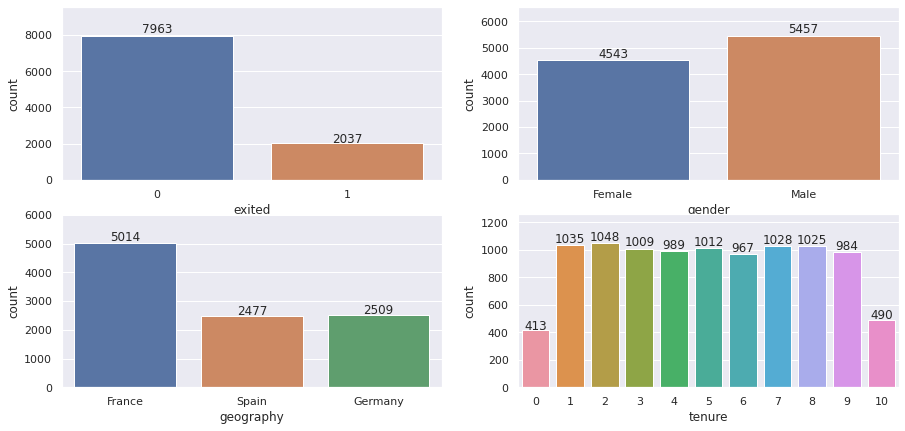

In [ ]:
# Inspección de datos categóricos
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
for i, col in enumerate(["exited", "gender", "geography", "tenure"]):
  g=sns.countplot(data=df, x=col, ax=ax.flat[i])
  max_value = df[col].value_counts().max() 
  ax.flat[i].set_ylim(0, max_value + max_value / 5) # Aumentar el limite del eje y para que no quede tan pegada cada figura
  for p in g.patches: # Poner un texto con la cantidad por cada clase
    g.text(x=p.get_x() + p.get_width()/2., y=p.get_height() + p.get_height()/50, s=p.get_height(), ha="center")    
plt.show()    

Convertimos la variable geografía en **variables dummy**, es decir, 3 nuevas variables binarias geography_France, geography_Germany, geography_Spain. En cada una de estas variables el 1 representa que el cliente pertenece a ese país, y 0 que no. Otra posible codificación habría sido números enteros consecutivos, sin embargo, en esta variable codificada así, **no se cumple la relación de orden total**, por lo que puede generar problemas en los algoritmos, por ejemplo que un algoritmo considere que una variable codificada con un número bajito es mucho menor que una variable con un número alto lo cuál no tiene sentido en este caso, por eso se usa escogió en este caso variables dummy

In [ ]:
df = pd.get_dummies(df, columns=["geography"])
df["gender"] = df["gender"].replace({"Female": 1, "Male": 0})

In [ ]:
target = "exited"
geography_features = [col for col in df.columns if col.startswith("geography")]
df.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


* La edad mínima de clientes encontrados en este dataset es de 18 años
* Llama la atención que hayan tantos clientes con balance en 0

In [ ]:
df[["creditscore", "balance", "estimatedsalary", "age"]].describe()

,creditscore,balance,estimatedsalary,age
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,100090.239881,38.921800
std,96.653299,62397.405202,57510.492818,10.487806
min,350.000000,0.000000,11.580000,18.000000
25%,584.000000,0.000000,51002.110000,32.000000
50%,652.000000,97198.540000,100193.915000,37.000000
75%,718.000000,127644.240000,149388.247500,44.000000
max,850.000000,250898.090000,199992.480000,92.000000


In [ ]:
# Buscar valores nulos, aparentemente no hay
df.isnull().sum()

creditscore          0
gender               0
age                  0
tenure               0
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
geography_France     0
geography_Germany    0
geography_Spain      0
dtype: int64

* Se tienen muy poca cantidad de variables, y la mayoría son categóricas. 
* Los rangos de las variables continuas difieren mucho, será indispensable escalar los datos para que los algoritmos no le de importancia a unas variables más que a otras o asegurarse de que usen mahalanobis. También es muy relevante escalar para acelerar la convergencia de la minimización de la función de costo en algunos algoritmos por ejemplo los que usan la optimización de una función de costo a través de descenso del gradiente.


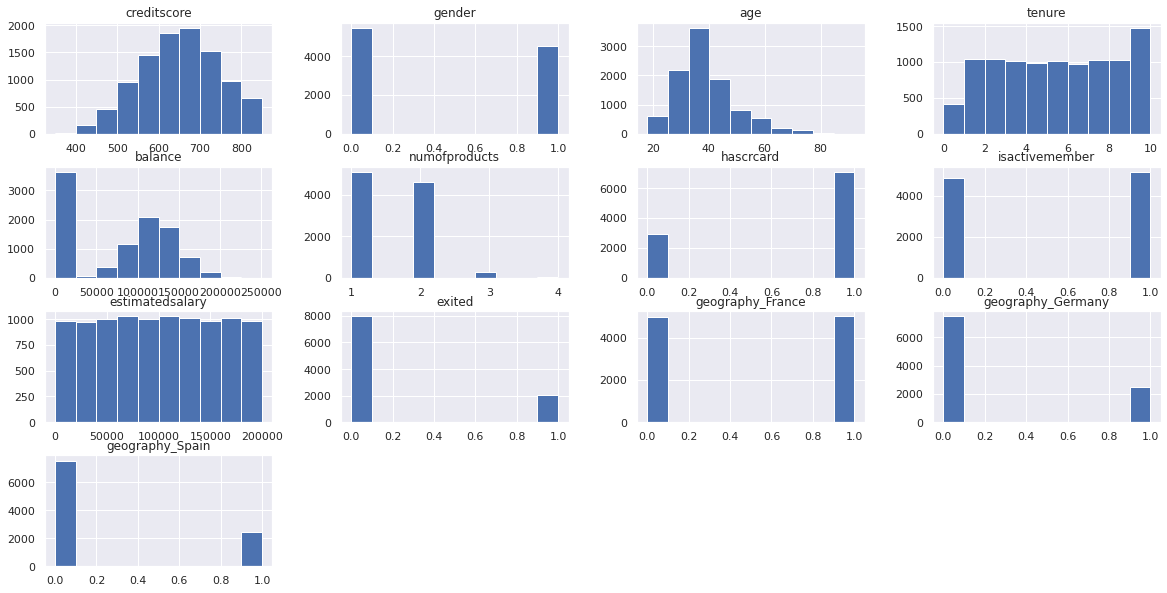

In [ ]:
df.hist(figsize=(20, 10))
plt.show()

### Credit score distribución detallada 

* El coeficiente de kurtosis ligeramente menor a 0 muestra que las colas de la distribución son más livianas que de la distribución normal.
* El coeficiente de asimetría ligeramente menor a 0 muestra que la distribución tiene una asimetría a la izquierda.
* Con el rango intercuartílico, en el diagrama de cajas y bigote se puede apreciar que hay algunos datos a la izquierda que podrían ser considerados como posibles outliers.
* Su coeficiente de variación es 0.148 lo que muestra que hay poca desviación estándar respecto a la media.

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: creditscore, dtype: float64
Asimetria (skewness) = -0.07160660820092675
Kurtosis = -0.42572568480291295
Coeficiente de variación = 0.14857650996563196


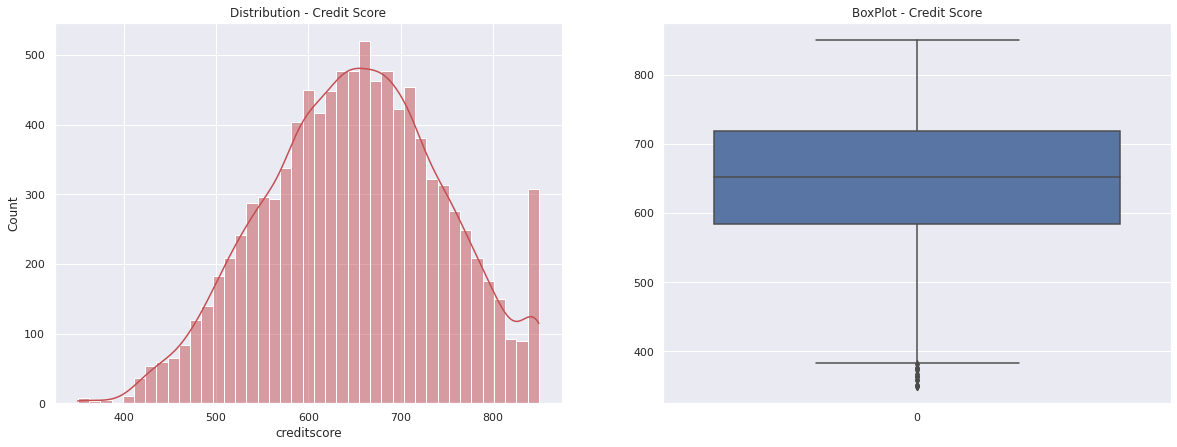

In [ ]:
# Distribuciones detalladas de las variables
# Credit Score
print(df['creditscore'].describe())
print("Asimetria (skewness) =", df['creditscore'].skew())
print("Kurtosis =", df['creditscore'].kurtosis())
print("Coeficiente de variación =", df["creditscore"].std() / df["creditscore"].mean())

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 7)
ax1.title.set_text('Distribution - Credit Score')
sns.histplot(df['creditscore'], color='r', kde=True, ax=ax1)
ax2.title.set_text('BoxPlot - Credit Score')
sns.boxplot(data=df['creditscore'], ax=ax2)
plt.show()

### Age distribución detallada 

* El coeficiente de kurtosis ligeramente mayor a 0 muestra que las colas de la distribución son más pesadas que de la distribución normal.
* El coeficiente de asimetría ligeramente mayor a 0 muestra que la distribución tiene una asimetría a la derecha.
* Con el rango intercuartílico, en el diagrama de cajas y bigote se puede apreciar que hay algunos datos a la derecha que podrían ser considerados como posibles outliers.
* Su coeficiente de variación es 0.269 lo que muestra que esta variable varía más que la distribución de credit score.

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64
Asimetria (skewness) = 1.0113202630234552
Kurtosis = 1.3953470615086956
Coeficiente de variación = 0.2694584128099058


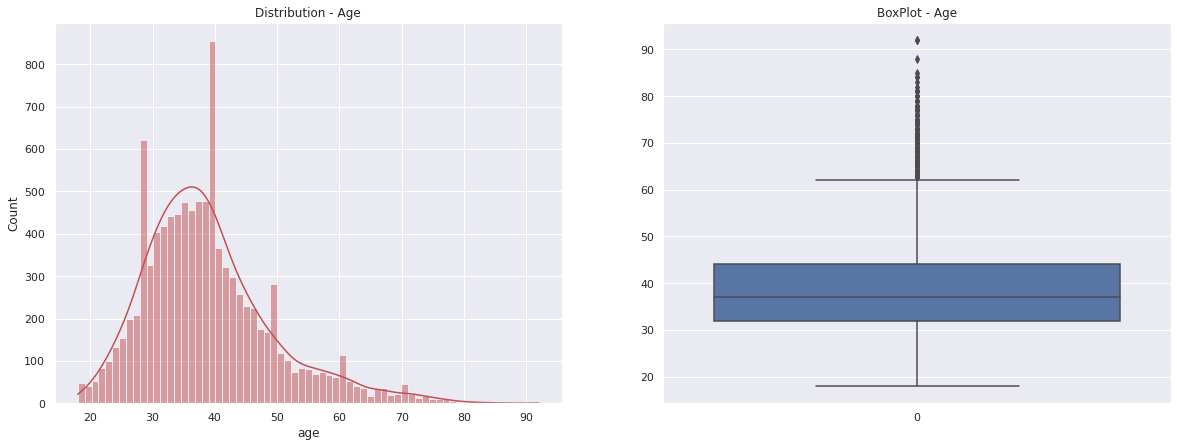

In [ ]:
# Distribuciones detalladas de las variables
# Age
print(df['age'].describe())
print("Asimetria (skewness) =", df['age'].skew())
print("Kurtosis =", df['age'].kurtosis())
print("Coeficiente de variación =", df["age"].std() / df["age"].mean())

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 7)
ax1.title.set_text('Distribution - Age')
sns.histplot(df['age'], color='r', kde=True, ax=ax1)
ax2.title.set_text('BoxPlot - Age')
sns.boxplot(data=df['age'], ax=ax2)
plt.show()

### Balance distribución detallada 

* Se puede observar una distribución aproximadamente normal, excepto por una cantidad considerable de datos que tienen un balance = 0 
* El coeficiente de kurtosis ligeramente menor a 0 muestra que las colas de la distribución son más livianas que de la distribución normal
* El coeficiente de asimetría ligeramente menor a 0 muestra que la distribución tiene una asimetría a la izquierda,  sin embargo, este efecto se debe a la gran cantidad de datos que hay en la cola izquierda de la distribución
* Con el rango intercuartílico, en el diagrama de cajas y bigote no puede apreciar algún outlier.
* Su coeficiente de variación es 0.815 lo que significa que esta variable varía muchísimo con respecto a su media, y esta es de las variables con mayor variación en este conjunto de datos.

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64
Asimetria (skewness) = -0.14110871094154384
Kurtosis = -1.489411767941925
Coeficiente de variación = 0.8158028334799813


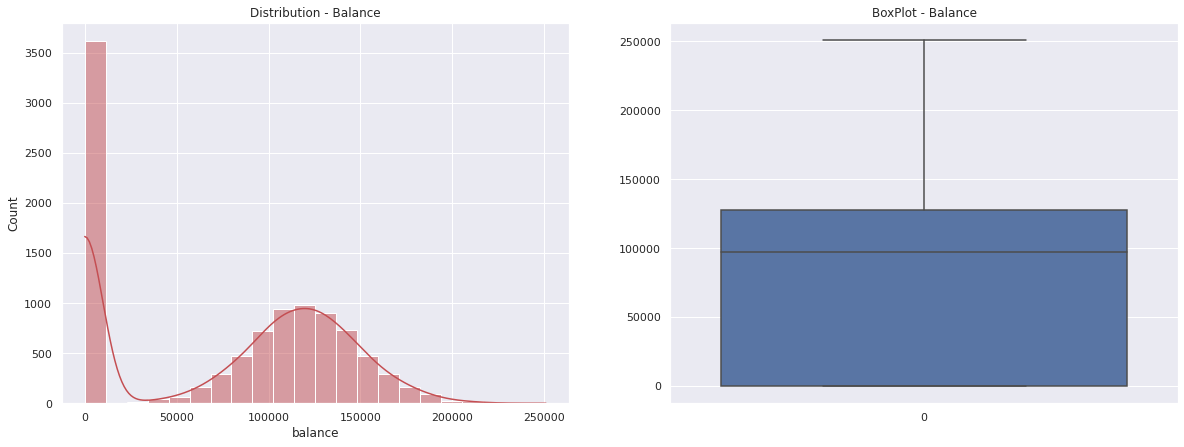

In [ ]:
# Distribuciones detalladas de las variables
# Balance
print(df['balance'].describe())
print("Asimetria (skewness) =", df['balance'].skew())
print("Kurtosis =", df['balance'].kurtosis())
print("Coeficiente de variación =", df["balance"].std() / df["balance"].mean())

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 7)
ax1.title.set_text('Distribution - Balance')
sns.histplot(df['balance'], color='r', kde=True, ax=ax1)
ax2.title.set_text('BoxPlot - Balance')
sns.boxplot(data=df['balance'], ax=ax2)

### Estimated salary distribución detallada 
* Esta distribución es aproximadamente uniforme.
* Ya que todos los eventos tienen la misma probabilidad, no hay datos outliers.
* Su coeficiente de variación es 0.57 lo que muestra que esta variable tiene una gran variación respecto a su media

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimatedsalary, dtype: float64
Coeficiente de variación = 0.5745864220734621


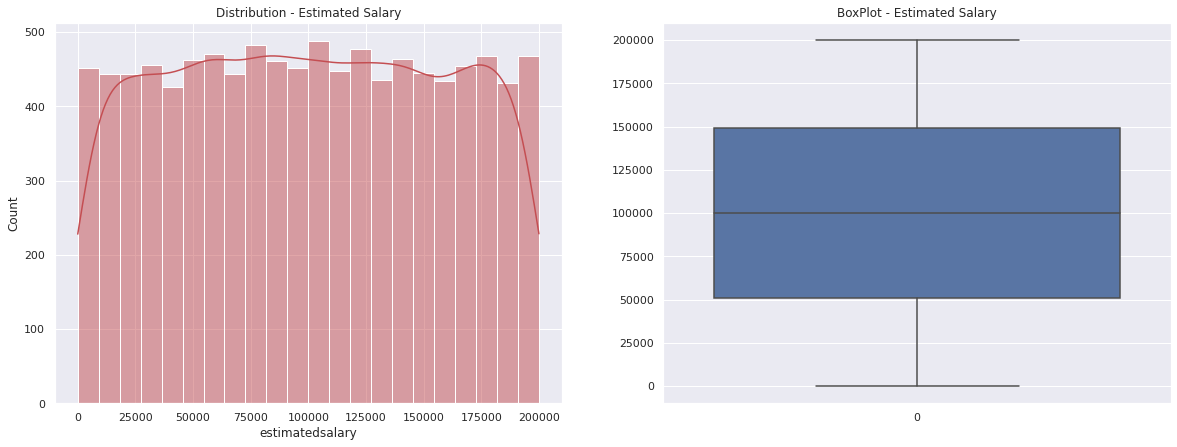

In [ ]:
# Distribuciones detalladas de las variables
# Estimatedsalary
print(df['estimatedsalary'].describe())
print("Coeficiente de variación =", df["estimatedsalary"].std() / df["estimatedsalary"].mean())

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 7)
ax1.title.set_text('Distribution - Estimated Salary')
sns.histplot(df['estimatedsalary'], color='r', kde=True, ax=ax1)
ax2.title.set_text('BoxPlot - Estimated Salary')
sns.boxplot(data=df['estimatedsalary'], ax=ax2)
plt.show()

## Analisis de Normalidad

Antes de realizar el estudio de correlación es importante realizar una prueba de normalidad en los datos. Esta se utiliza para analizar si las distribuciones en los datos siguen una distribución gaussiana (normal) o no y así corroborar con los aspectos preliminares que se revisaron en el análisis exploratorio.
 
En este caso, realizaremos la prueba para las variables que no representan categorías ni representaciones binarias, en este caso analizaremos según las pruebas exploratorias: credit score, age, tenure, balance y estimatedsalary.

La prueba de Anderson-Darling es una prueba estadística que se puede utilizar para evaluar si una muestra de datos proviene de una de las muchas muestras de datos conocidas, que lleva el nombre de Theodore Anderson y Donald Darling.

Se puede utilizar para comprobar si una muestra de datos es normal. La prueba es una versión modificada de una prueba estadística de bondad de ajuste no paramétrica más sofisticada llamada prueba de Kolmogorov-Smirnov.

Una característica de la prueba de Anderson-Darling es que devuelve una lista de valores críticos en lugar de un solo valor p. Esto puede proporcionar la base para una interpretación más completa del resultado.


In [ ]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson

def anderson_dar(data):
  seed(1)
  # normality test
  result = anderson(data)
  print('Statistic: %.3f' % result.statistic)
  p = 0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
      print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

#creditscore
print("Credit Score -------")
anderson_dar(df["creditscore"].values.tolist())
#age
print("Age -------")
anderson_dar(df["age"].values.tolist())
#tenure
print("Tenure -------")
anderson_dar(df["tenure"].values.tolist())
#balance
print("Balance -------")
anderson_dar(df["balance"].values.tolist())
#estimatedsalary
print("Estimated Salary -------")
anderson_dar(df["estimatedsalary"].values.tolist())

Credit Score -------
Statistic: 5.458
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
Age -------
Statistic: 142.194
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
Tenure -------
Statistic: 151.154
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
Balance -------
Statistic: 651.853
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data doe

Podemos interpretar los resultados si no rechazamos la hipótesis nula de que los datos son normales si el estadístico de prueba calculado es menor que el valor crítico en un nivel de significancia elegido.

Por lo que para las variables que revisamos en el análisis exploratorio podemos observar que la distribución de los datos rechaza la hipótesis nula por lo que no seguirá la distribución gaussiana. Ya que los estadísticos de prueba en cada distribución superan al valor crítico que representa una distribución normal.

## Analisis de correlaciones


Primero realizaremos una proyección para ver el comportamiento de pares de variables y así visualmente poder observar la relación de una variable con otra.


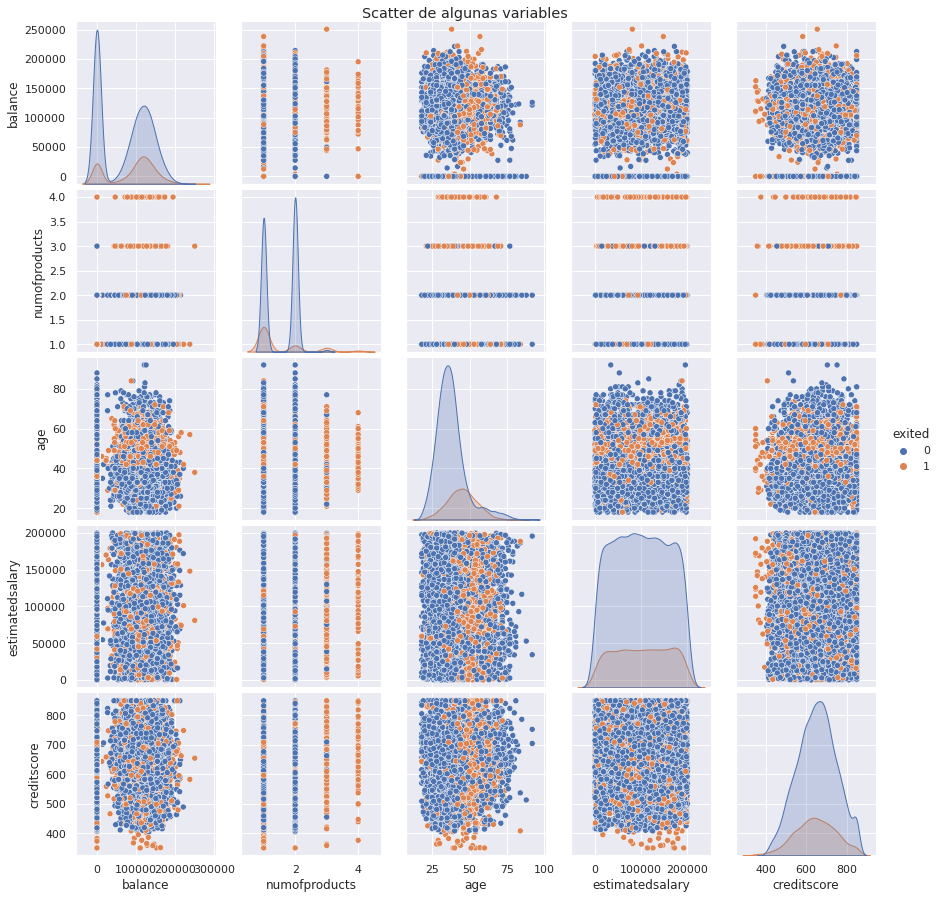

In [ ]:
g = sns.pairplot(data=df, vars=["balance", "numofproducts", "age", "estimatedsalary", "creditscore"], hue=target)
g.fig.suptitle("Scatter de algunas variables", y=1)
plt.show()

No hay correlaciones muy fuertes, pero algunos elementos a resaltar es que se observa que hay una tendencia de que las personas con mayor número de productos, se cambien de bancos, también se obsera que entre unos 40 años a 60 años aproximadamente hay una mayor cantidad de personas que cambian de banco.

Conocemos que la correlación en los datos es una de las estrategias en estadística descriptiva con la que se busca estimar la relación lineal entre las variables que conforman las observaciones.
Para la correlación entre variables utilizamos diferentes métodos, los cuales se listan en los siguientes:
Primero utilizamos la correlación de **Kendall**, la cual es buena para variables ordinales en este caso puede ser el valor crediticio que tienen las personas en el banco y el balance acumulado que tienen en las cuentas. Como este indicador está basado en rangos y no en los datos originales, su estimación requiere que los valores de la variable ordinal sean transformados en rangos, este coeficiente se ve poco afectado ante la presencia de un número pequeño de valores atípicos (extremos) en la muestra estudiada, adaptándose bien en aquellas variables que reportan moderadas asimetrías en torno a la relación general
 
Aplicando este método de correlación podemos observar como en una matriz se relaciona 1-1 cada dato. De estas observamos que en la diagonal tenemos una correlación de 1 pero se explica por la comparación de la variable consigo misma. 
 
Resaltando el caso de estudio, podemos observar que tenemos correlaciones bastantes bajas en el set de datos, aproximándonos en muchos casos a un valor de cero. Para la explicación de nuestra variable estudiada que es la cantidad de personas que se quedan o se salen del banco, observamos algo muy peculiar. Tenemos una alta correlación con el género, la edad y si es miembro activo. Esto de entrada nos puede mostrar relaciones entre una variable y la otra, pero no causalidad.



In [ ]:
corr_kendall = df.corr(method='kendall')
corr_kendall.style.background_gradient(cmap='coolwarm').set_precision(2)

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain
creditscore,1.00,0.00,-0.01,0.00,0.00,0.01,-0.00,0.02,0.00,-0.02,-0.01,0.00,0.00
gender,0.00,1.00,0.02,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.11,-0.01,0.02,-0.02
age,-0.01,0.02,1.00,-0.01,0.02,-0.05,-0.01,0.03,-0.00,0.27,-0.04,0.05,0.00
tenure,0.00,-0.01,-0.01,1.00,-0.01,0.01,0.02,-0.02,0.01,-0.01,-0.00,-0.00,0.00
balance,0.00,-0.01,0.02,-0.01,1.00,-0.27,-0.01,-0.01,0.01,0.09,-0.18,0.32,-0.11
numofproducts,0.01,0.01,-0.05,0.01,-0.27,1.00,0.00,0.02,0.01,-0.12,0.01,-0.02,0.01
hascrcard,-0.00,-0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.00,0.01,-0.01
isactivemember,0.02,-0.02,0.03,-0.02,-0.01,0.02,-0.01,1.00,-0.01,-0.16,0.00,-0.02,0.02
estimatedsalary,0.00,0.01,-0.00,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,-0.00,0.01,-0.01
exited,-0.02,0.11,0.27,-0.01,0.09,-0.12,-0.01,-0.16,0.01,1.00,-0.10,0.17,-0.05


Realizamos por otro lado el análisis de correlaciones con el coeficiente de **Spearman**. Este valor es de gran utilidad en aquellos análisis de datos en donde se desea conocer la relación lineal entre variables cuyas escalas de medidas sean al menos ordinales, o que exista suficientes evidencias de que las variables en estudio a pesar de ser cuantitativas no siguen un comportamiento normal. Además, este método no califica por los valores de las variables sino por la clasificación en rangos de las mismas variables.
La matriz de resultados nos muestra a diferencia de la anterior unas correlaciones más elevadas, mostrando más variables que explican nuestra variable estudiada, resaltando> género, edad, balance, número de productos, es activo y si pertenece a alemania. Este cambio se debe a que el método utiliza una serie de rangos diferentes a el método de Kendall lo que permite evidenciar y resaltar correlaciones que no eran tan notorias con el método anterior.


In [ ]:
corr_spearman = df.corr(method='spearman')
corr_spearman.style.background_gradient(cmap='Oranges').set_precision(2)

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain
creditscore,1.00,0.00,-0.01,0.00,0.01,0.01,-0.00,0.02,0.00,-0.02,-0.01,0.01,0.00
gender,0.00,1.00,0.03,-0.02,-0.01,0.01,-0.01,-0.02,0.01,0.11,-0.01,0.02,-0.02
age,-0.01,0.03,1.00,-0.01,0.03,-0.06,-0.02,0.04,-0.00,0.32,-0.05,0.06,0.00
tenure,0.00,-0.02,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01,-0.00,-0.00,0.00
balance,0.01,-0.01,0.03,-0.01,1.00,-0.32,-0.01,-0.01,0.01,0.11,-0.21,0.37,-0.13
numofproducts,0.01,0.01,-0.06,0.01,-0.32,1.00,0.00,0.02,0.01,-0.13,0.01,-0.02,0.02
hascrcard,-0.00,-0.01,-0.02,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.00,0.01,-0.01
isactivemember,0.02,-0.02,0.04,-0.03,-0.01,0.02,-0.01,1.00,-0.01,-0.16,0.00,-0.02,0.02
estimatedsalary,0.00,0.01,-0.00,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,-0.00,0.01,-0.01
exited,-0.02,0.11,0.32,-0.01,0.11,-0.13,-0.01,-0.16,0.01,1.00,-0.10,0.17,-0.05


Por último, intentamos la correlación de Pearson. La correlación de Pearson evalúa la relación lineal entre dos variables continuas. Una relación es lineal cuando un cambio en una variable se asocia con un cambio proporcional en la otra variable. Esta asimismo se diferencia de las correlaciones anteriores ya que la correlación anterior evalúa relaciones monótonas entre variables, es decir, variables que cambian al mismo tiempo pero no al mismo ritmo. Mientras que el método de Pearson se basa en los datos sin jerarquizar ni procesar.
 
Al revisar los datos de esta correlación tendremos correlaciones parecidas al método anterior. Podemos resaltar nuevamente las variables género, edad, balance y si es miembro activo. Con estas revisamos cuales son los posibles elementos que más influyen en el caso de estudio en los usuarios.


In [ ]:
corr_pearson = df.corr(method='pearson')
corr_pearson.style.background_gradient(cmap='Accent').set_precision(2)

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain
creditscore,1.00,0.00,-0.00,0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03,-0.01,0.01,0.00
gender,0.00,1.00,0.03,-0.01,-0.01,0.02,-0.01,-0.02,0.01,0.11,-0.01,0.02,-0.02
age,-0.00,0.03,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29,-0.04,0.05,-0.00
tenure,0.00,-0.01,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01,-0.00,-0.00,0.00
balance,0.01,-0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12,-0.23,0.40,-0.13
numofproducts,0.01,0.02,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05,0.00,-0.01,0.01
hascrcard,-0.01,-0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.00,0.01,-0.01
isactivemember,0.03,-0.02,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16,0.00,-0.02,0.02
estimatedsalary,-0.00,0.01,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,-0.00,0.01,-0.01
exited,-0.03,0.11,0.29,-0.01,0.12,-0.05,-0.01,-0.16,0.01,1.00,-0.10,0.17,-0.05


Podemos concluir que los mejores resultados para explicar el comportamiento de los usuarios frente a la retirada en el banco, son más adecuadamente extraídos por medio de los métodos de Pearson y Spearman. Para este caso utilizaremos las correlaciones de Spearman, debido a que estudian la correlación lineal entre dos variables, sin la necesidad de jerarquizar en rangos ni procesar, por lo que podremos tener una mejor aproximación a los datos crudos y su naturaleza para la explicación de las correlaciones.

Y del estudio de correlaciones podemos concluir de primera mano, que estamos contando con una matriz muy poco correlacionada, lo cual al momento de introducir técnicas como PCA se pueden presentar problemas por la falta de correlación entre las variables estudiadas. En contexto al caso de estudio tenemos que preliminarmente la variable que estamos estudiando (la salida de los clientes en el banco) tiene gran relación con el género, la edad, el balance de las cuentas de cada usuario, si es miembro activo y por último, si este se encuentra en alemania. Estos indicadores nos permiten pensar de antemano que estas variables de una forma u otra afectan a que los usuarios salgan del banco, por lo que será de gran necesidad prestarle atención a estas mismas en los próximos pasos de preprocesamiento e ingeniería de características en los datos.
 
Es importante recalcar que estas variables a pesar de representar una relación una con otra, no representan causalidad. Por lo que será necesario seguir estudiando las relaciones en las variables para poder concluir algo de esta índole.


### Correlaciones con variables más significativas
 
Del estudio de correlaciones realizado anteriormente, vamos a realizar un estudio más detallado con cada variable que tenía un coeficiente de correlación mayor. De esta manera, vamos a graficar su comportamiento con la variable de estudio y ver como es la relación respecto a la variable.

Para este primer caso vamos a visualizar un mapa de puntos, el cual relaciona a la variable mas correlacionada que es edad, con los puntos crediticios.

Text(0.5, 1.0, 'Credit Score vs. Age')

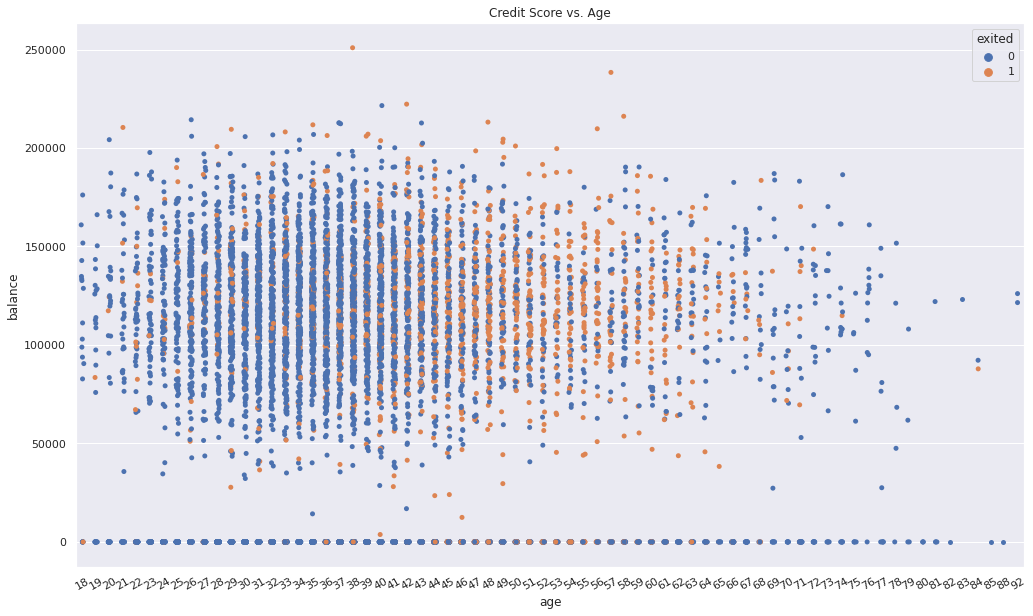

In [ ]:
g = sns.stripplot(x="age", y="balance", hue="exited", data=df)
sns.set(rc={'figure.figsize':(17,10)})
g.set_xticklabels(g.get_xticklabels(),rotation=30);
g.set_title("Credit Score vs. Age")

Sorprendentemente podemos observar un patrón super interesante en la edad y el comportamiento de un usuario que usualmente se sale del banco. Podemos visualizar que la mayoría de personas que hacen parte del grupo de usuarios que abandonan están en la parte central de la gráfica. Observemos la representación de esta porción sin los otros datos de personas que no abandonan.

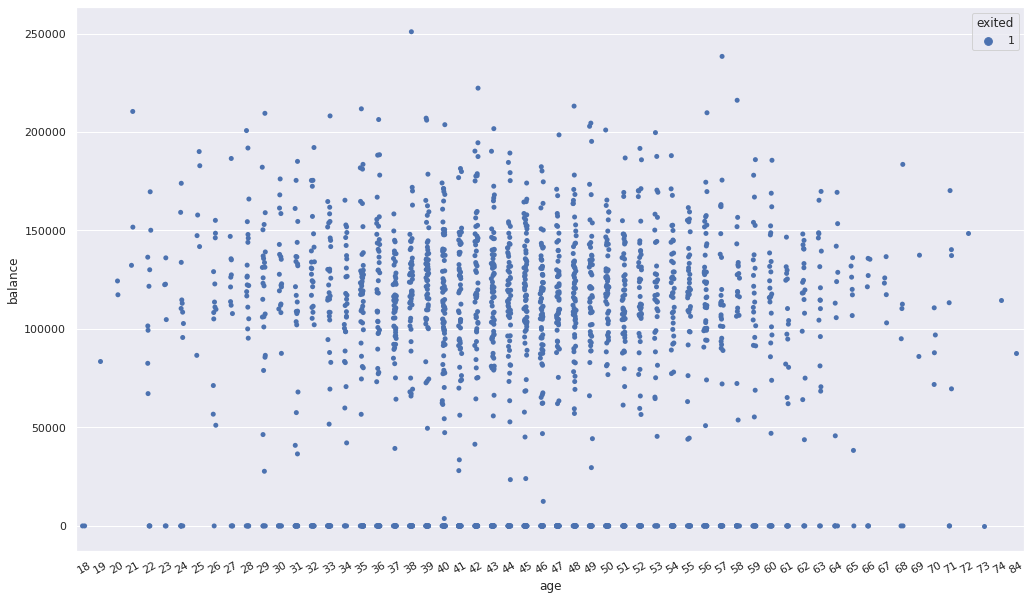

In [ ]:
data_frame_exited = df[df["exited"]==1]
g3 = sns.stripplot(x="age", y="balance", hue="exited", data=data_frame_exited)
sns.set(rc={'figure.figsize':(17,10)})
g3.set_xticklabels(g3.get_xticklabels(),rotation=30);

Sin duda podemos corroborar la informacion anterior, la concentracion de los puntos se enecuntra en la zona central. Para visualizar y sacar un estimado, miremos la dirtibucion de estos datos en otra grafica y hallemos los percentiles que contienen la mayor cantidad de informacion.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


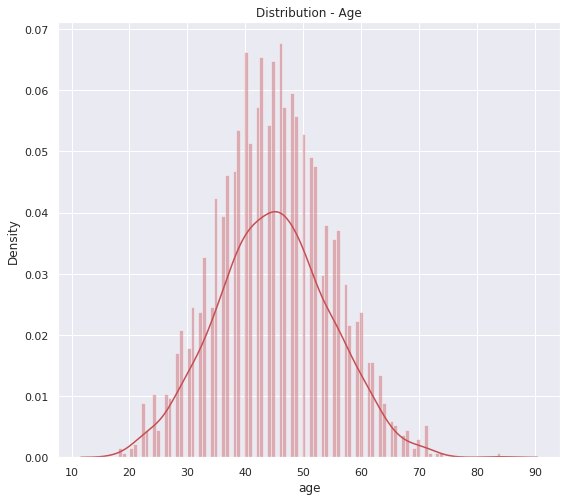

In [ ]:
plt.figure(figsize=(9, 8))
plt.title("Distribution - Age")
sns.distplot(data_frame_exited['age'], color='r', bins=100);

In [ ]:
# Lets plot the quantiles
age_exited = data_frame_exited['age']
age_exited.quantile([.05, .5, .95])

0.05    29.0
0.50    45.0
0.95    61.0
Name: age, dtype: float64

Como podemos observar en el análisis, tenemos un escenario a resaltar en el estudio de los clientes. Este es que las edades en las cuales la mayoría de ellos tienden a salirse del banco está concentrada en las edades 29 a 61. Esto puede dar cabida a muchos análisis y resultados para el banco, entre ellos puede ser porque los usuarios buscan más estabilidad económica en otras opciones cuando están al inicio de su vida adulta por lo que migran de facultades. En las edades mayores y menores a estas se puede decir que ya sea por la inmadurez o la estabilidad a una edad mayor, no se busca cambiar de opciones. Lo cual podría abrir al banco estrategias para incentivar a los usuarios entre este rango de edad para que busquen la mejor alternativa en el banco estudiado en cuestión.

Otro análisis que podemos observar es en el género, una de las variables más correlacionadas con la variable a predecir. Primero observaremos como es la proporción de hombres y mujeres en comparativa a la totalidad de personas que tienden a abandonar el banco.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


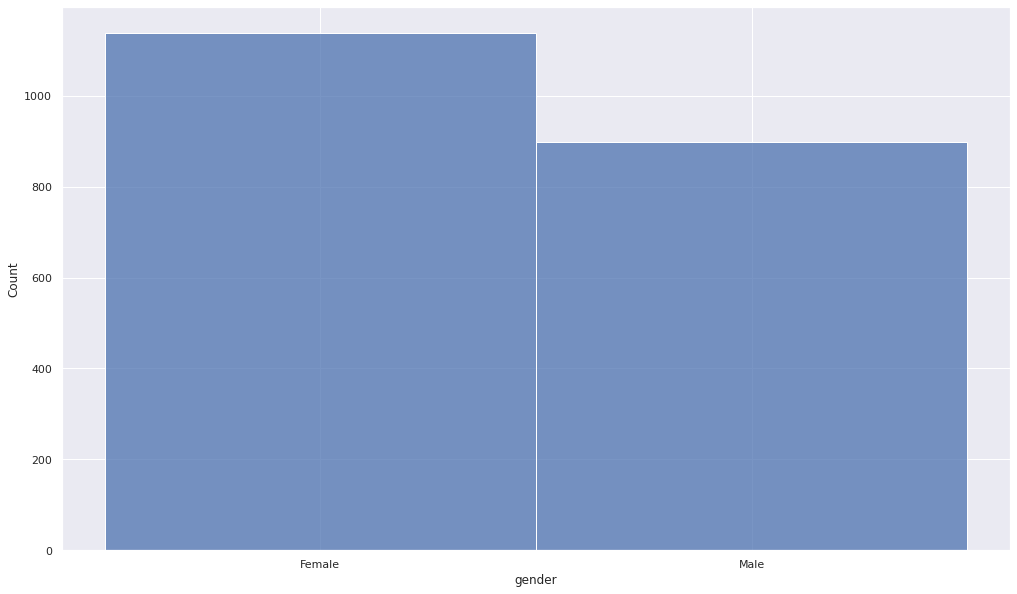

In [ ]:
data_frame_exited["gender"] = data_frame_exited["gender"].replace({1:"Female", 0:"Male"});
sns.histplot(data=data_frame_exited, x='gender')

Podemos observar claramente que la porción de mujeres es mucho mayor que la de hombres al momento de salir la organización. Esto puede ser significativo, debido a que el banco puede estar incentivando mejores estrategias para la población masculina y no la femenina. Lo cual es importante tener en cuenta.



Por último y no menos importante, observamos que la tercera variable más correlacionada está relacionada con la zona geográfica donde está ubicado el usuario. Visualicemos como es la proporción de los usuarios y su comportamiento.

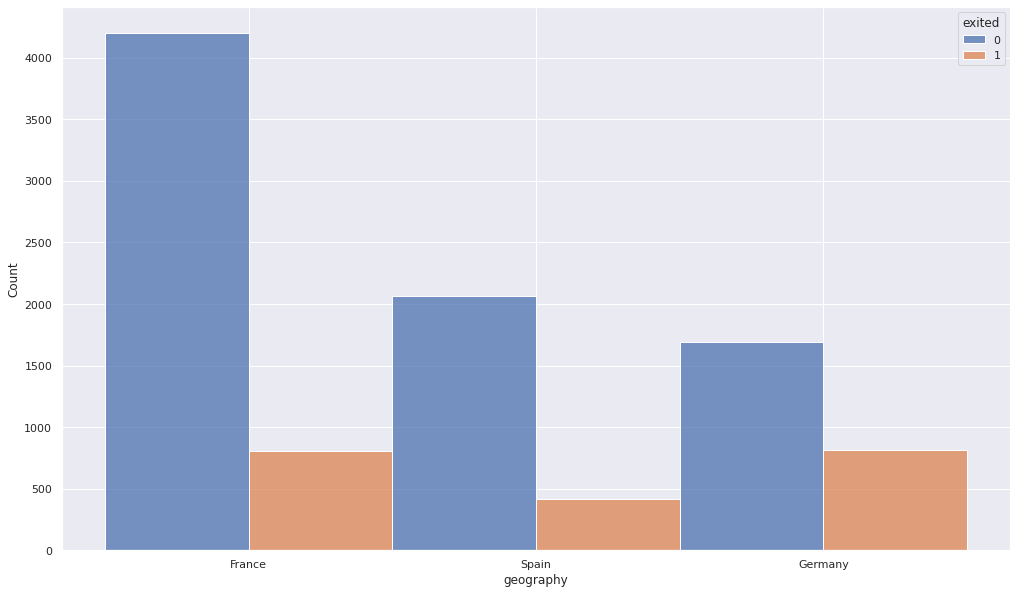

In [ ]:
sns.histplot(data=data_frame_raw, x="geography", hue="exited", multiple="dodge")

In [ ]:
# Proportions
germany_exits = int(data_frame_raw.loc[(data_frame_raw['geography'] == 'Germany') & (data_frame_raw['exited'] == 1)].count()[0])
germany_nexits = int(data_frame_raw.loc[(data_frame_raw['geography'] == 'Germany') & (data_frame_raw['exited'] == 0)].count()[0])
print('Germany: Amount of exited: {} Amount of non-exited: {} Proportion Exited: {}'.format(germany_exits, germany_nexits, round((germany_exits/(germany_exits+germany_nexits)), 2)))

france_exits = int(data_frame_raw.loc[(data_frame_raw['geography'] == 'France') & (data_frame_raw['exited'] == 1)].count()[0])
france_nexits = int(data_frame_raw.loc[(data_frame_raw['geography'] == 'France') & (data_frame_raw['exited'] == 0)].count()[0])
print('France: Amount of exited: {} Amount of non-exited: {} Proportion Exited: {}'.format(france_exits, france_nexits, round((france_exits/(france_exits+france_nexits)), 2)))

spain_exits = int(data_frame_raw.loc[(data_frame_raw['geography'] == 'Spain') & (data_frame_raw['exited'] == 1)].count()[0])
spain_nexits = int(data_frame_raw.loc[(data_frame_raw['geography'] == 'Spain') & (data_frame_raw['exited'] == 0)].count()[0])
print('Spain: Amount of exited: {} Amount of non-exited: {} Proportion Exited: {}'.format(spain_exits, spain_nexits, round((spain_exits/(spain_exits+spain_nexits)), 2)))

Germany: Amount of exited: 814 Amount of non-exited: 1695 Proportion Exited: 0.32
France: Amount of exited: 810 Amount of non-exited: 4204 Proportion Exited: 0.16
Spain: Amount of exited: 413 Amount of non-exited: 2064 Proportion Exited: 0.17


Sin duda se puede concluir lo que se evidencia en el análisis de las correlaciones, se encuentra que el país que tiende a presentar mayores casos de personas que abandonan el banco se encuentra en Alemania con un porcentaje de 32% esto implicaría concentrarse mayormente en este país y así revisar una estrategia para que los usuarios en este lugar sientan una mejor tracción y estabilidad en el banco.

### Correlaciones Múltiples
 
Por otro lado, implementando librerías entregadas en la clase de estadística se pudo explicar la relación de una variable con el resto. Esto permite evidenciar desde otra perspectiva las conclusiones de los pasos anteriores. Pero dando robustez en la explicación por el hecho de no hacer una comparación de pares, sino de 1 a muchos.


In [ ]:
import funciones_Estadisticas

s=funciones_Estadisticas.Matriz_covarianzasCorregida(df.values)
s_menos_uno = np.linalg.inv(s)
DD = np.diag(s_menos_uno)*np.diag(s)
DD_inverso = DD**-1
print('')
print('Estos son los coeficientes de correlacion multiple entre cada variable y el resto:\n')
UNO_menos_DD_inverso = 1 - DD_inverso
print(pd.Series(UNO_menos_DD_inverso, index=df.columns))
print('')
argmax = np.argmax(UNO_menos_DD_inverso)
print(f'La variable mas predecible por el resto es {df.columns[argmax]} R2 = {UNO_menos_DD_inverso[argmax]} ')
print(f'En otros terminos, el resto de las variables explica el {(UNO_menos_DD_inverso[argmax] * 100).round(4)}% de la variabilidad de esta variable')


Estos son los coeficientes de correlacion multiple entre cada variable y el resto:

creditscore          0.001641
gender               0.013038
age                  0.099486
tenure               0.002151
balance              0.253311
numofproducts        0.109529
hascrcard            0.001615
isactivemember       0.044546
estimatedsalary      0.001047
exited               0.150793
geography_France     1.000000
geography_Germany    1.000000
geography_Spain      1.000000
dtype: float64

La variable mas predecible por el resto es geography_France R2 = 0.9999999999999986 
En otros terminos, el resto de las variables explica el 100.0% de la variabilidad de esta variable


### Dependencia directa entre pares: Correlaciones parciales
Se observa un resultado similar a la matriz de correlaciones, se mantiene que la mayor correlación con exited es la variable age con 0.3, aún así sigue siendo un valor bastante bajo.

In [ ]:
def correlacionesParciales(x):
    """
    funcion para calcular las correlaciones entre pares de variables
    """
    S=funciones_Estadisticas.Matriz_covarianzasCorregida(x) 
    SdiaINV = np.diag(np.linalg.inv(S))**-0.5 #son las varianzas poblacionales
    matriz_D = np.diag(SdiaINV) #matriz cuadrada diagonal cuya diagonal es Sdia
    return -1 * matriz_D @ np.linalg.inv(S) @ matriz_D

Text(0.5, 1.0, 'Partial Correlation Heatmap')

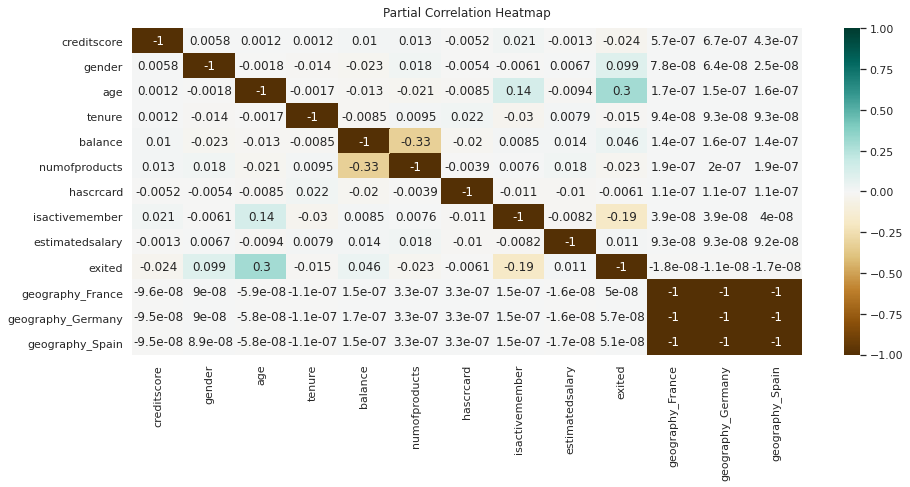

In [ ]:
plt.figure(figsize=(15, 6))

heatmap = sns.heatmap(pd.DataFrame(correlacionesParciales(df.values), index=df.columns, columns=df.columns), annot=True, vmin=-1, vmax=1, cmap="BrBG")
heatmap.set_title('Partial Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


### La dependencia lineal
* Explica solo el 2.8% de la variabilidad del conjunto de datos **sin incluir las variables dummy.**
* Explica el 92%  de la variabilidad de los datos con las variables dummy



In [ ]:
# Sin variables dummy
corr_matrix = df.drop(columns=geography_features).corr()
Det = np.linalg.det(corr_matrix)
n_features = corr_matrix.shape[0]
D = 1 - Det**(1/(n_features-1))
print(f"{D * 100:.4f}%")

2.8292%


In [ ]:
# Con variables dummy
corr_matrix = df.corr()
Det = np.linalg.det(corr_matrix)
n_features = corr_matrix.shape[0]
D = 1 - Det**(1/(n_features-1))
print(f"{D * 100:.4f}%")

92.1284%


Con este resultado tenemos un marco de cuales son las variables más representativas para la explicación de la variable estudiada. Por otro lado, antes de realizar alguna conclusión definitiva es importante tener en cuenta la causalidad, la cual explica la influencia de una variable a otra. No solo su relación, sino la dirección de cómo la variable explicada es influida por la variable explicativa.
 


## Causalidad

La causalidad es la forma de investigar si una variable ocasiona a la otra. Colocando ambas en una serie de tiempo y por medio de metodos probabilisticos se busca patrones en los datos de las correlaciones.

Causalidad esta relacionada con la idea de causa efecto, sin embargo no es lo mimso. En este escenario estamos analisando en una serie de tiempo si los valores de una variable pueden causar los resultados de otra.

Para esto propusimos el metodo de Wiener-Granger y poder observar la causalidad de las variables mas significativas en las correlaciones y revisar su causalidad en la variable a predecir en este caso 'exited'.

Para entender el metodo, primero tenemos que crear un set de datos donde la primera columna sea la variable a predecir y la segunda la variable explicativa. Este realiza la hipotesis nula: la serie de la segunda columna no es causa de la primera con un cierto retraso. Así, si se obtiene p-valores por debajo del nivel de significancia se puede rechazar la hipótesis concluyendo que la causalidad existe.

Se realiza la prueba con cada una de las variables en este caso.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print('Gender ----------------------------------')
data = df[['exited','gender']].values
grangercausalitytests(data, maxlag=1)
print()
print('Age ----------------------------------')
data = df[['exited','age']].values
grangercausalitytests(data, maxlag=1)
print()

print('Balance ----------------------------------')
data = df[['exited','balance']].values
grangercausalitytests(data, maxlag=1)
print()

print('Tenure ----------------------------------')
data = df[['exited','tenure']].values
grangercausalitytests(data, maxlag=1)
print()

print('Num of Products ----------------------------------')
data = df[['exited','numofproducts']].values
grangercausalitytests(data, maxlag=1)
print()

print('Has Credit Card ----------------------------------')
data = df[['exited','hascrcard']].values
grangercausalitytests(data, maxlag=1)
print()

print('Active Member ----------------------------------')
data = df[['exited','isactivemember']].values
grangercausalitytests(data, maxlag=1)
print()

print('Estimated Salary ----------------------------------')
data = df[['exited','estimatedsalary']].values
grangercausalitytests(data, maxlag=1)
print()

print('From Germany  ----------------------------------')
data = df[['exited','geography_Germany']].values
grangercausalitytests(data, maxlag=1)
print()

print('From Spain  ----------------------------------')
data = df[['exited','geography_Spain']].values
grangercausalitytests(data, maxlag=1)
print()

print('From France  ----------------------------------')
data = df[['exited','geography_France']].values
grangercausalitytests(data, maxlag=1)
print()

print('Credit Score ----------------------------------')
data = df[['exited','creditscore']].values
grangercausalitytests(data, maxlag=1)


Gender ----------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3254  , p=0.1273  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=2.3261  , p=0.1272  , df=1
likelihood ratio test: chi2=2.3259  , p=0.1272  , df=1
parameter F test:         F=2.3254  , p=0.1273  , df_denom=9996, df_num=1

Age ----------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0061  , p=0.9378  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=0.0061  , p=0.9378  , df=1
likelihood ratio test: chi2=0.0061  , p=0.9378  , df=1
parameter F test:         F=0.0061  , p=0.9378  , df_denom=9996, df_num=1

Balance ----------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6601  , p=0.1976  , df_denom=9996, df_num=1
ssr based chi2 test:   chi2=1.6606  , p=0.1975  , df=1
likelihood ratio test: chi2=1.6604  , p=0.1975  , df=1
parameter F test:         F=1.6601  

{1: ({'lrtest': (2.426709963445319, 0.11928301604531938, 1),
   'params_ftest': (2.426276288622914, 0.11934768629495553, 9996.0, 1.0),
   'ssr_chi2test': (2.4270044628316385, 0.11926060371573148, 1),
   'ssr_ftest': (2.426276288675373, 0.1193476862908567, 9996.0, 1)},
   array([[0., 1., 0.]])])}

De los resultados obtenidos podemos resaltar que para rechazar la hipótesis nula y así poder establecer la relación de causalidad, el valor esperado de p debe estar próximo al valor de 0. Al rechazar la hipótesis nula, concluimos que hay que rechazar la idea de que no hay una relación entre las variables.
 
En este caso no obtenemos ningún valor próximo a cero. Sin embargo, las variables que más se aproximan a rechazar la hipótesis nula son el género, balance en la cuenta y el puntaje crediticio. Esto nos permite tomar la hipótesis de que estas variables son importantes al momento de que un cliente decide o no quedarse en el banco y así podremos concentrarnos en estas variables para explicar el fenómeno.


## Integracion PCA

In [ ]:
cv = KFold(n_splits=5, random_state=random_state, shuffle=True)

**PCA**
El análisis de componentes principales (Principal Component Analysis PCA) es un método de reducción de dimensionalidad que permite simplificar la complejidad de espacios con múltiples dimensiones a la vez que conserva su información.
El método de PCA permite por lo tanto "condensar" la información aportada por múltiples variables en solo unas pocas componentes. Aun así, no hay que olvidar que sigue siendo necesario disponer del valor de las variables originales para calcular las componentes. Dos de las principales aplicaciones del PCA son la visualización y el preprocesado de predictores previo ajuste de modelos supervisados.

**Eigenvectors**: Los eigenvectors de una matriz son todos aquellos vectores que, al multiplicarlos por dicha matriz, resultan en el mismo vector o en un múltiplo entero del mismo.
**Eigenvalue**: Al valor por el que se multiplica el eigenvector resultante se le conoce como eigenvalue. A todo eigenvector le corresponde un eigenvalue y viceversa.
En el método PCA, cada una de las componentes se corresponde con un eigenvector, y el orden de componente se establece por orden decreciente de eigenvalue. Así pues, la primera componente es el eigenvector con el eigenvalue más alto.

Al trabajar con varianzas, el método PCA es muy sensible a outliers, por lo que es recomendable estudiar si los hay


**Media y varianza:** Al obtener la media y la varianza de cada variable, podemos observar que el orden de dimensionalidad entre las variables es muy diferente, por lo que surge la necesidad de estandarizar la dimensión de las variables. Si no se estandarizan las variables para que tengan media cero y desviación estándar de uno antes de realizar el estudio PCA, las variable estimatedsalary, balance, creditscore que tienen una media y dispersión muy superior al resto, dominarán la mayoría de las componentes principales.

In [ ]:
pca_pipeline = make_pipeline(StandardScaler(), PCA())
pca_pipeline.fit(df)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipeline.named_steps['pca']

In [ ]:
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = df.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13']
)

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain
PC1,-1.049041e-03,4.782741e-02,1.565479e-01,-1.242665e-02,4.733114e-01,-1.785814e-01,-7.565496e-03,-5.633113e-02,1.539968e-02,2.953569e-01,-0.533608,0.583676,0.031878
PC2,2.885660e-02,-5.690990e-02,-8.609466e-02,2.142384e-02,-2.286222e-01,1.693322e-01,-1.354458e-02,7.635487e-02,-1.510759e-02,-1.750176e-01,-0.520208,-0.155395,0.758604
PC3,-8.833357e-02,3.434570e-01,5.714992e-01,-3.454546e-02,-2.854256e-01,1.963195e-01,-3.960732e-02,-1.706065e-01,1.826097e-02,5.920379e-01,0.047621,-0.170659,0.116235
PC4,-5.779030e-03,1.852543e-01,-3.607052e-01,2.337841e-01,-1.974019e-01,6.155788e-01,1.872191e-01,-3.894592e-01,1.643783e-01,-1.268294e-02,-0.105570,0.316012,-0.195091
PC5,3.235948e-01,3.611353e-02,2.539764e-01,-1.986103e-01,-1.116146e-01,4.458916e-01,-9.922567e-02,6.708691e-01,-3.644947e-02,-1.302647e-01,-0.049461,0.247793,-0.191568
PC6,7.523761e-02,2.845846e-01,-2.418771e-01,-4.746314e-01,4.195296e-02,-1.650773e-02,-6.620640e-01,-1.501511e-01,4.056363e-01,-3.352848e-02,0.002158,-0.023473,0.021075
PC7,2.057549e-01,-2.135347e-01,1.855556e-01,5.557274e-01,3.418805e-02,-6.717502e-02,-1.089729e-01,1.172588e-01,7.289657e-01,2.559770e-02,0.033107,-0.061648,0.023566
PC8,-8.686028e-01,-2.708583e-01,7.730413e-02,-1.483083e-01,-4.462948e-02,1.594245e-01,-3.697779e-02,1.958150e-01,2.513140e-01,-4.508755e-02,-0.032213,0.089750,-0.052825
PC9,-7.575829e-02,-2.602341e-01,3.703166e-02,4.241052e-01,-3.519479e-02,1.430731e-01,-7.048291e-01,-1.039189e-01,-4.546754e-01,3.285487e-02,-0.005644,0.066961,-0.060712
PC10,2.788832e-01,-7.473457e-01,1.093485e-01,-4.086405e-01,-7.822330e-02,1.573073e-01,6.173140e-02,-3.414535e-01,6.461050e-02,1.689264e-01,0.001712,0.018629,-0.020691


Podemos ver aquí que ninguna componente recoge mayoritariamente la información de varias de las variables explicadas, a excepción de la última, que recoge mayoritariamente la información geográfica de los países.

•	La influencia de las variables en cada componente analizarse visualmente con un gráfico de tipo heatmap.

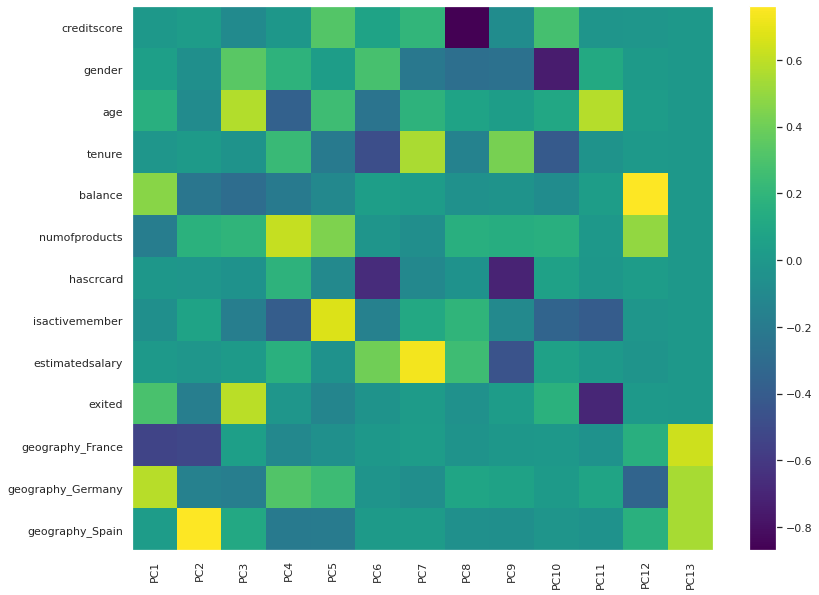

In [ ]:
#La influencia de las variables en cada componente
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 10))
componentes = modelo_pca.components_
index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13']
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(df.columns)), df.columns)
plt.xticks(range(len(index)),labels=index,rotation=90)
plt.grid(False)
plt.colorbar();

Acá podemos observar que cada componente tiene una, máximo dos variables que tienen gran influencia sobre ellas, lo que nos muestra que al final es como si cada componente se le estuviera atribuyendo a cada variable, lo cual no es bueno, pues la idea de PCA es reducir la dimensionalidad de las variables que explican el set de datos.

**Proporción de varianza explicada**

Una de las preguntas más frecuentes que surge tras realizar un PCA es: ¿Cuánta información presente en el set de datos original se pierde al proyectar las observaciones en un espacio de menor dimensión? o lo que es lo mismo ¿Cuanta información es capaz de capturar cada una de las componentes principales obtenidas? Para contestar a estas preguntas se recurre a la proporción de varianza explicada por cada componente principal.


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.1496 0.117  0.0959 0.086  0.0831 0.0785 0.0769 0.0763 0.0748 0.0727
 0.0474 0.0418 0.    ]


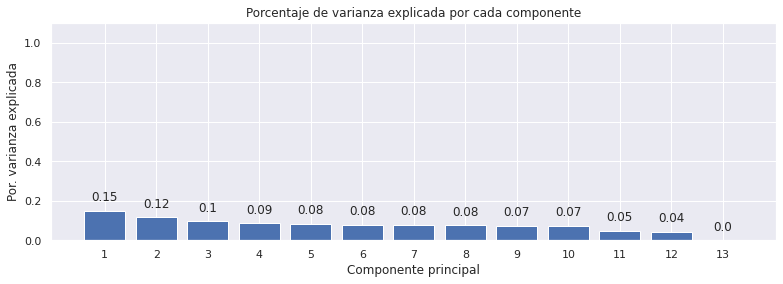

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_.round(4))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 4))
ax.bar(
    x = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13']
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
#ax.set_xticks()
#ax.set_xticks(index)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

Una vez calculadas las componentes principales, podemos conocer la varianza explicada por cada una de ellas, la proporción respecto al total y la proporción de varianza acumulada. En este caso podemos ver que la proporción respecto al total de cada componente es mínima, dado que la varianza explicada de cada una de ellas es muy pequeña con respecto al total, por ejemplo la primera componente solo explica el 15% de la varianza observada y la segunda el 12%, valores muy bajos para pensar en que aplicar PCA dará un buen resultado. 

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.14964549 0.26666388 0.36251948 0.44854491 0.53162817 0.61007869
 0.6869607  0.76325529 0.83809782 0.91081437 0.95823818 1.
 1.        ]


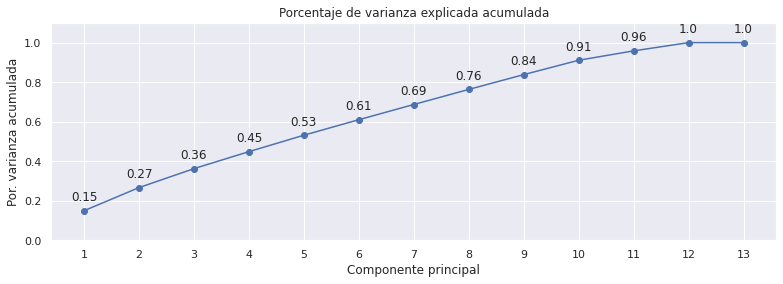

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 4))
ax.plot(
    np.arange(len(df.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

si nos fijamos en la varianza acumulada, podemos ver que el impacto que tiene cada una de las componentes es mínimo, ninguna presenta un cambio significativo en cuanto a la varianza observada, sino mas bien, parece como si trazaran una recta a medida que vamos iterando las componentes.

In [ ]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipeline.transform(X=df)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13'],
    index   = df.index
)
proyecciones.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-0.669199,-1.138631,1.839294,-0.918270,0.191461,0.047227,-0.641199,0.101771,-1.289472,-0.452968,-1.523810,-1.057808,-7.396883e-16
1,0.383350,1.810895,0.217892,-1.817247,0.238344,1.941383,-0.522765,0.368640,-0.231436,-1.052550,0.203793,-0.085890,5.407267e-16
2,0.019452,-1.287951,2.164619,2.000612,-0.715001,-0.588774,0.044035,0.942767,0.192483,-0.600256,-0.685119,2.649880,-7.396883e-16
3,-1.623648,-0.492919,0.908053,0.536201,0.425510,2.097536,-0.986084,-0.545547,0.468695,0.278259,0.829107,-0.301367,-8.507106e-16
4,0.697075,1.700408,-0.194534,-1.636513,0.757279,0.259089,-0.420366,-2.099981,-1.572705,-0.429138,0.258070,0.476100,7.627713e-16


**LogisticRegression + PCA**

El método consiste en ajustar un modelo de regresión logística por mínimos cuadrados empleando como predictores las componentes generadas a partir de un Principal Component Analysis (PCA). De esta forma, con un número reducido de componentes se puede explicar la mayor parte de la varianza de los datos.
Si las variables están correlacionadas entre ellas, la información que aportan es redundante y además, se incumple la condición de no colinealidad necesaria en la regresión por mínimos cuadrados. Dado que el PCA es útil eliminando información redundante, si se emplean como predictores las componentes principales, se puede mejorar el modelo de regresión. Es importante tener en cuenta que, si bien lo que buscamos es reducir el número de predictores del modelo, este método no se puede considerar como un método de selección de variables ya que todas ellas se necesitan para el cálculo de las componentes. La identificación del número óptimo de componentes principales que se emplean como predictores puede identificarse por validación cruzada.


Se ajusta el modelos lineal por medio de un pipeLine, el cual primero estandarizará los valores de las variables, aplicará PCA a los datos y posterior entregará las componentes obtenidas a un modelo de regresión logística.

In [ ]:
pca_pipeline_logistic = make_pipeline(StandardScaler(), PCA(), LogisticRegression())

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 12]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pca_pipeline_logistic,
        param_grid = param_grid,
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = cv, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = df.drop(target, axis=1), y = df[target])

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) 

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
5,10,0.312473,0.007567,0.317144,0.005621
6,12,0.309351,0.005263,0.315927,0.005196
4,8,0.144214,0.017707,0.154343,0.006636
3,6,0.123276,0.030995,0.116371,0.021860
2,4,0.001026,0.002051,0.000971,0.000900
0,1,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000


Aguí podemos ver que los mejores resultados los obtendremos con 10 de las componentes entregadas por PCA, y esto es claro, ya que 3 de ellas corresponden a las variables dumies que construimos a partir de la variable geography, la cual tenía la descripción de 3 países.

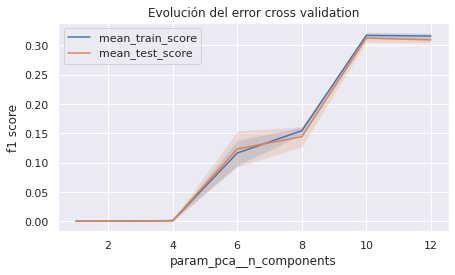

In [ ]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error cross validation')
ax.set_ylabel('f1 score');

Los resultados de validación cruzada muestran que el mejor modelo, en este caso usando regresión logística, se obtiene empleando las 10 primeras componentes entregadas por PCA.

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'pca__n_components': 10} : 0.3124734444002969 f1


# Data preparation

## Modelos base antes de preparación de datos
Antes de buscar outliers y hacer oversampling se desea conocer el desempeño de 3 modelos base para tener una idea de qué tan bien funcionan los modelos sin preprocesamiento y cuál se desempeña mejor entre ellos. Se usará la métrica de f1-score y además se analizará el desempeño usando validación cruzada

**Cross validation**

Para comparar los distintos método en el conjunto de entrenamiento se usó la validación cruzada, que es un método de validación que pretende reducir la varianza en la estimación de la medida de evaluación del modelo que surge como resultado de particionar los datos de una manera en específico. Para ilustrar un poco más por qué se da esta varianza, considere el caso en el que una partición de datos hayan quedado ejemplos más difíciles en el conjunto de validación, entonces el modelo, que fue entrenado con datos más fáciles, no podrá generalizar bien en el conjunto de validación y por tanto la medida de evaluación del modelo dependerá de cómo se dividieron estos datos.

Para reducir este problema, en la validación cruzada se dividen los datos en k subconjuntos, se entrena en k-1 y se deja uno para validar, se entrena el modelo y evalúa. Este procedimiento se repite k veces para que todos los subconjuntos tengan oportunidad de ser conjunto de validación una vez. Finalmente, se devuelve k valores de evaluación del modelo al que se le puede sacar la media y la desviación estándar para obtener una mejor idea del valor promedio de medida de su modelo y que tanto varía la evalucación en el conjunto de entrenamiento


In [ ]:
def display_scores_cross_validation(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation",  scores.std())

In [ ]:
X = df.drop(target, axis=1)
y = df[target]

In [ ]:
scaler = MinMaxScaler().fit(X)
X_base_scaled = scaler.transform(X)

### Logistic Regression

In [ ]:
scores_logistic = cross_val_score(LogisticRegression(), X_base_scaled, y, scoring="f1", cv=cv)
display_scores_cross_validation(scores_logistic)

Scores: [0.30122592 0.30943396 0.30584192 0.29787234 0.30501931]
Mean: 0.30387869030943865
Standard deviation 0.003978184729546872


In [ ]:
pca_pipeline_logistic = make_pipeline(StandardScaler(), PCA(n_components=10), LogisticRegression())
scores_pca_logistic = cross_val_score(pca_pipeline_logistic, X, y, scoring="f1", cv=cv)
display_scores_cross_validation(scores_pca_logistic)

Scores: [0.30636833 0.30337079 0.31810491 0.31060606 0.32391714]
Mean: 0.3124734444002969
Standard deviation 0.007566893688595732


### Random forest

In [ ]:
scores_random_forest = cross_val_score(RandomForestClassifier(), X_base_scaled, y, scoring="f1", cv=cv)
display_scores_cross_validation(scores_random_forest)

Scores: [0.60294118 0.59968102 0.59058488 0.56466877 0.55332303]
Mean: 0.5822397750062571
Standard deviation 0.019734762409657294


In [ ]:
pca_pipeline_forest = make_pipeline(StandardScaler(), PCA(n_components=10), RandomForestClassifier())
scores_pca_forest = cross_val_score(pca_pipeline_forest, X, y, scoring="f1", cv=cv)
display_scores_cross_validation(scores_pca_forest)

Scores: [0.53996983 0.53745928 0.53512706 0.50662252 0.50949367]
Mean: 0.5257344720447795
Standard deviation 0.01454213064656983


### K neighbors

In [ ]:
scores_k_neighbors = cross_val_score(KNeighborsClassifier(), X_base_scaled, y, scoring="f1", cv=cv)
display_scores_cross_validation(scores_k_neighbors)

Scores: [0.43880597 0.42424242 0.40118871 0.34325744 0.4097561 ]
Mean: 0.4034501284631594
Standard deviation 0.032712058175812825


In [ ]:
pca_pipeline_k_neighbors = make_pipeline(StandardScaler(), PCA(n_components=10), KNeighborsClassifier())
scores_pca_k_neighbors = cross_val_score(pca_pipeline_k_neighbors, X, y, scoring="f1", cv=cv)
display_scores_cross_validation(scores_pca_k_neighbors)

Scores: [0.45074627 0.44666667 0.44346549 0.43097643 0.42718447]
Mean: 0.4398078648485747
Standard deviation 0.009136897704452076


### Comparativa de modelos

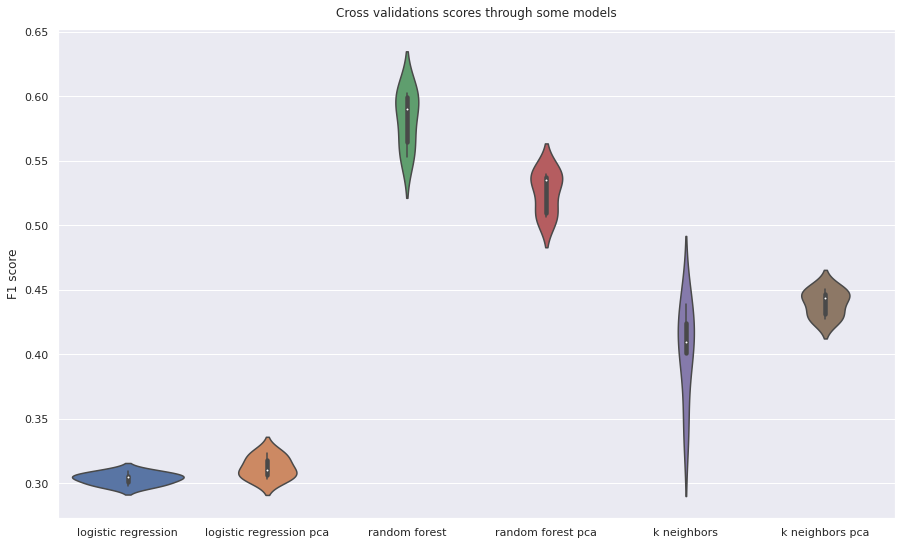

In [ ]:
plt.figure(figsize=((15, 9)))
scores_df = pd.DataFrame({"logistic regression": scores_logistic, "logistic regression pca": scores_pca_logistic, 
                          "random forest": scores_random_forest, "random forest pca": scores_pca_forest,
                          "k neighbors": scores_k_neighbors, "k neighbors pca": scores_pca_k_neighbors})
g = sns.violinplot(data=scores_df, orient ='v')
g.set_title('Cross validations scores through some models', fontdict={'fontsize':12}, pad=12)
g.set_ylabel ("F1 score")
plt.show()

### Conclusión modelos base

Estos valores se obtuvieron con todo el conjunto de datos, dan una comparativa del desempeño del algoritmo en el conjunto de validación que es una partición del conjunto de entrenamiento, pero estos son valores preliminares debido a que hasta este punto del análisis no se ha hecho la partición del conjunto de entrenamiento y conjunto de pruebas que es dónde se puede probar realmente la generalización final del modelo.

* Se puede observar en el gráfico de violin que la regressión logística sin PCA es la que tiene un peor desempeño f1 score tiene en promedio, además que se observa como incluso en una iteración del algoritmo de cross validation, llegó hasta un f1-score de 0.25

* El mejor modelo fue random forest sin PCA con un promedio de 0.58, superando al segundo mejor que fue random forest con PCA

* PCA ayuda un poco a la regresión logística, y ayuda un poco al modelo de vecinos más cercanos, pero empeora el desempeño de random forest. Sin embargo, las diferencias no son muy grandes, ya que el número de componentes para lograr una explicabilidad de la varianza alta, es muy grande (10 componentes principales cuando se tiene 13 variables) debido a que las variables están muy incorreladas entre sí. Por lo que se podría preferir seguir usando el modelo sin PCA

## Outliers Univariantes

Para remover los outliers univariantes, seguimos técnicas básicas las cuales se encargan de a partir de las desviaciones estándar de las distribuciones, dejar los datos que se encuentran más cerca de la media. Con este propósito, evitar datos atípicos en los extremos generados por una asimetría o por datos que se salen de la distribución que siguen la mayoría de los datos.
 
Para esto, realizamos una búsqueda por cada variable en nuestro dataset. Y a cada una de estas le calcularemos el puntaje Z. El cual es un indicativo que permite evidenciar que tan lejos están los datos de la medida central (media) y utiliza el concepto de desviaciones estándar para medir la distancia de los puntos a su respectiva media.

El procedimiento para realizarlo se llevó a cabo con dos desviaciones estándar, según las distribuciones que siguen las variables el mejor valor para reducir los datos atípicos o colas, fue 3 desviaciones estándar. Sabemos por teoría que una distribución normal se encuentra a 3 desviaciones estándar de su media central por esa razón, se llevó a cabo esta decisión.


In [ ]:
from scipy.stats import zscore
z_scores = zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_old = df.copy()
#df = df[filtered_entries].reset_index(drop=True)

In [ ]:
# Cantidad de outliers eliminados
np.where(~filtered_entries)[0].shape

(201,)

## Outliers multivariante

In [ ]:
from sklearn.covariance import MinCovDet, LedoitWolf

In [ ]:
n_samples = df.shape[0]
mean_data = df.mean()
cov_data =  df.cov() 
dMahalanobis_basic = np.zeros(n_samples)

for i in range(n_samples):
  dMahalanobis_basic[i] = ((df.iloc[i, :] - mean_data) @ (np.linalg.inv(cov_data) @ (df.iloc[i, :] - mean_data).T))**(1/2)

In [ ]:
lw = LedoitWolf().fit(df)
dMahalanobis_lw = lw.mahalanobis(df)

In [ ]:
mcd = MinCovDet().fit(df)
dMahalanobis_mcd = mcd.mahalanobis(df)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (8.986040818163531 > 7.672912826815050). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (6.860846527180065 > 6.764413049965270). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (9.731446758331259 > 9.073450225185340). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)


In [ ]:
print("Numero condición")
print("Método normal",  np.linalg.cond(df.cov()))
print("Método  Ledoit and Wolf", np.linalg.cond(lw.covariance_))
print("Método del mínimo determinante de covarianza", np.linalg.cond(mcd.covariance_))
print()
print("Determinante")
print("Método normal",  np.linalg.det(df.cov()))
print("Método Ledoit and Wolf", np.linalg.det(lw.covariance_))
print("Método del mínimo determinante de covarianza", np.linalg.det(mcd.covariance_))

Numero condición
Método normal 7.869839589234616e+24
Método  Ledoit and Wolf 36679.51055582094
Método del mínimo determinante de covarianza 7.383051704062918e+24

Determinante
Método normal 2067665.9323657278
Método Ledoit and Wolf 2.721101192522286e+74
Método del mínimo determinante de covarianza -782171.9135863103


### Comparacion determinantes y número condición matrices de covarianza

El número condición es un valor que expresa para pequeños cambios en la entrada, cuánto será la magnitud del cambio en la salida, así pues si se introducen errores a un algoritmo, cuánto error se agregaría a la salida. 

Se puede observar que la matriz de covarianzas que tiene un mayor número condición es el método normal, le sigue el método de determinante de covarianza con un número condición también bastante elevado, y finalmente Ledoit and Wolf reduce considerablemente el valor de el número condición de la matriz de covarianza. 

Sin embargo, todas la matrices tienen muy alto su determinante, mostrando que las matrices se alejan de ser singulares, y que las variables están muy incorreladas entre sí, es decir hay mucha independencia entre las columnas.


### Graficos mahalanobis
En las distribuciones se puede apreciar la forma que toman las distancias de Mahalanobis para cada método, se observa que en Ledoit and Wolf bastante pronunciado respecto a los otros métodos. 

Sin embargo, el método que más evidencia posibles outliers es el método del mínimo determinante de covarianza. 

**Explicación método del mínimo determinante de covarianza** es un método robusto para calcular la matriz de covarianzas ante la presencia de grupos de outliers. Los grupos de valores atípicos afectan precisamente el vector de medias y la matriz de covarianzas debido a que atraen los vectores propios hacia ellos. Por tanto, Mahalanobis puede considerar datos outliers, a los que no los son, y considerar normales los datos que sí son outliers. 

Para evitar este problema hay muchas técnicas, entre ellas el método del mínimo determinante de covarianza. La intuición y descripción a alto nivel del algoritmo para calcular esta matriz de covarianza se basa en el entendimiento del concepto de determinante, que en 2 dimensiones se puede ver como la caja con área mínima, donde se pueden meter los datos. Gráficamente los vectores propios de los datos en dos dimensiones definen una caja, y precisamente la multiplicación de sus valores propios es igual al determinante y el área de esa caja dónde se encuentran los datos, es decir, el determinante de la matriz de covarianzas, también llamada **varianza generalizada** es una medida que nos indica la dispersión nuestros datos. Así se puede llevar la intuición de dos dimensiones a 3 o más dimensiones, pensando en el volumen o hipervolumen definido por los vectores propios de la matriz de covarianzas. 

La estimación robusta de la mátriz de covarianzas por el método del mínimo determinante de covarianza trata de buscar múltiples subconjuntos de datos de un tamaño h (generalmente se usa la fórmula (n_ejemplos + n_features + 1) / 2) y selecciona la matriz de covarianzas con el mínimo determinante, es decir, se escoge el subconjunto de tamaño h con los datos que menor dispersión tengan, y así se espera excluir las anomalías que lo que hacen es aumentar la dispersión. Luego esta matriz es multiplicada por un factor de consistencia para compensar el hecho de que se seleccionó de un subconjunto de datos y así se calcula matriz de covarianzas robusta.

In [ ]:
def show_plots_mahalanobis(dMahalanobis, title=""):
  print(pd.Series(dMahalanobis).describe())
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13,4))

  ax1.title.set_text('Distribution - Mahalanobis ' + title)
  sns.histplot(dMahalanobis, color='r', kde=True, ax=ax1)

  ax2.title.set_text('BoxPlot - Mahalanobis ' + title)
  sns.boxplot(x=dMahalanobis, ax=ax2)
  plt.show()

count    10000.000000
mean         3.419113
std          0.568233
min          2.093210
25%          3.036729
50%          3.349762
75%          3.718392
max          6.835688
dtype: float64


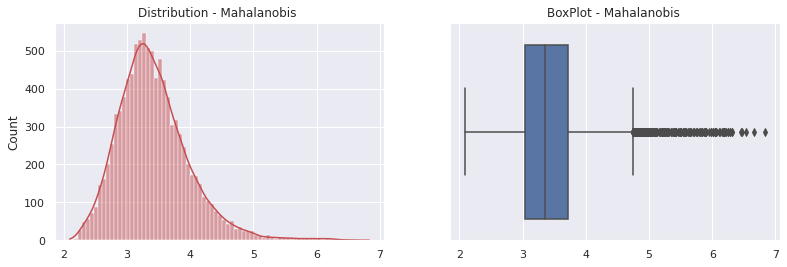

In [ ]:
# Distribuciones detalladas de mahalanobis
show_plots_mahalanobis(dMahalanobis_basic)

count    10000.000000
mean         2.082284
std          1.157091
min          0.006061
25%          1.254884
50%          1.935851
75%          2.853990
max          7.949890
dtype: float64


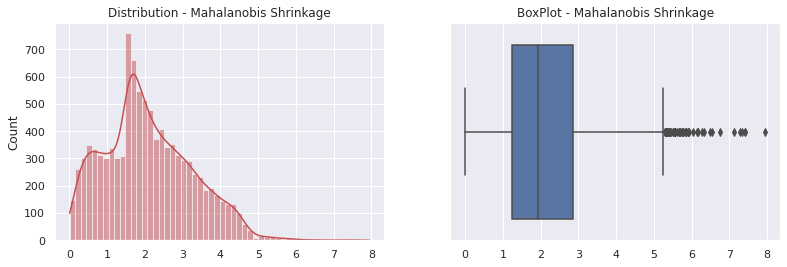

In [ ]:
show_plots_mahalanobis(dMahalanobis_lw, "Shrinkage")

count    10000.000000
mean        13.464966
std          6.444669
min          4.495200
25%          9.711788
50%         11.997540
75%         15.025557
max         72.465152
dtype: float64


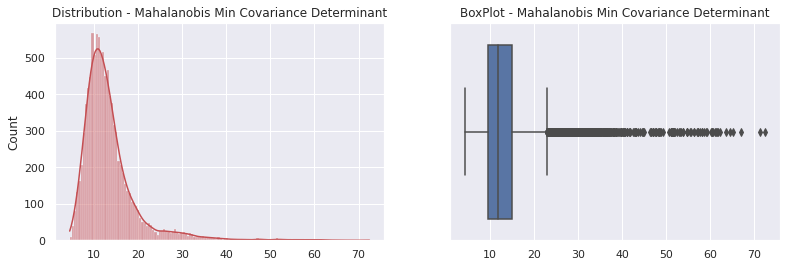

In [ ]:
show_plots_mahalanobis(dMahalanobis_mcd, "Min Covariance Determinant")

### Eliminación de outliers multivariante

In [ ]:
I_basic = np.where(dMahalanobis_basic > np.percentile(dMahalanobis_basic, 90))[0]
X_without_outliers_basic = df.drop(I_basic).drop(target, axis=1)
y_without_outliers_basic = df.drop(I_basic)[target]

In [ ]:
I_lw = np.where(dMahalanobis_lw > np.percentile(dMahalanobis_lw, 90))[0]
X_without_outliers_lw =  df.drop(I_lw).drop(target, axis=1)
y_without_outliers_lw =  df.drop(I_lw)[target]

In [ ]:
I_cmd = np.where(dMahalanobis_mcd > np.percentile(dMahalanobis_mcd, 90))[0]
X_without_outliers_cmd = df.drop(I_cmd).drop(target, axis=1)
y_without_outliers_cmd = df.drop(I_cmd)[target]

### Evaluación del modelo con los distintos métodos de eliminación de outliers


In [ ]:
print("With outliers")
scaler = MinMaxScaler().fit(df.drop(target, axis=1))
X_scaled = scaler.transform(df.drop(target, axis=1))
scores_with_outliers = cross_val_score(LogisticRegression(), X_scaled, df[target], scoring="f1", cv=cv)
display_scores_cross_validation(scores_with_outliers)
print()

print("With outliers PCA")
scaler = MinMaxScaler().fit(df.drop(target, axis=1))
X_scaled = scaler.transform(df.drop(target, axis=1))
scores_with_outliers_pca = cross_val_score(pca_pipeline_logistic, X_scaled, df[target], scoring="f1", cv=cv)
display_scores_cross_validation(scores_with_outliers_pca)
############################# Basic Method #############################
print("Without outliers from covariance basic method")
scaler = MinMaxScaler().fit(X_without_outliers_basic)
X_scaled_basic = scaler.transform(X_without_outliers_basic)
scores_basic = cross_val_score(LogisticRegression(), X_scaled_basic, y_without_outliers_basic, scoring="f1", cv=cv)
display_scores_cross_validation(scores_basic)
print()

print("Without outliers from covariance basic method PCA")
scaler = MinMaxScaler().fit(X_without_outliers_basic)
X_scaled_basic = scaler.transform(X_without_outliers_basic)
scores_basic_pca = cross_val_score(pca_pipeline_logistic, X_scaled_basic, y_without_outliers_basic, scoring="f1", cv=cv)
display_scores_cross_validation(scores_basic_pca)
print()

############################# Method lw #############################
print("Without outliers from covariance lw")
scaler = MinMaxScaler().fit(X_without_outliers_lw)
X_scaled_lw = scaler.transform(X_without_outliers_lw)
scores_lw = cross_val_score(LogisticRegression(), X_scaled_lw, y_without_outliers_lw, scoring="f1", cv=cv)
display_scores_cross_validation(scores_lw)
print()

print("Without outliers from covariance PCA")
scaler = MinMaxScaler().fit(X_without_outliers_lw)
X_scaled_lw = scaler.transform(X_without_outliers_lw)
scores_lw_pca = cross_val_score(pca_pipeline_logistic, X_scaled_lw, y_without_outliers_lw, scoring="f1", cv=cv)
display_scores_cross_validation(scores_lw_pca)
print()

############################# Method Min Covariance Determinante #############################
print("Without outliers from covariance Min Covariance Determinant")
scaler_cmd = MinMaxScaler().fit(X_without_outliers_cmd)
X_scaled_cmd = scaler_cmd.transform(X_without_outliers_cmd)
scores_cmd = cross_val_score(LogisticRegression(), X_scaled_cmd, y_without_outliers_cmd, scoring="f1", cv=cv)
display_scores_cross_validation(scores_cmd)

print("Without outliers from covariance Min Covariance Determinant PCA")
scaler_cmd = MinMaxScaler().fit(X_without_outliers_cmd)
X_scaled_cmd = scaler_cmd.transform(X_without_outliers_cmd)
scores_cmd_pca = cross_val_score(pca_pipeline_logistic, X_scaled_cmd, y_without_outliers_cmd, scoring="f1", cv=cv)
display_scores_cross_validation(scores_cmd_pca)

With outliers
Scores: [0.30122592 0.30943396 0.30584192 0.29787234 0.30501931]
Mean: 0.30387869030943865
Standard deviation 0.003978184729546872

With outliers PCA
Scores: [0.30636833 0.30337079 0.31810491 0.31060606 0.32391714]
Mean: 0.3124734444002969
Standard deviation 0.007566893688595732
Without outliers from covariance basic method
Scores: [0.4354067  0.46261682 0.43147208 0.39175258 0.45255474]
Mean: 0.4347605848115818
Standard deviation 0.024304413267845576

Without outliers from covariance basic method PCA
Scores: [0.40481928 0.43165468 0.43734644 0.4195122  0.44      ]
Mean: 0.42666651716716303
Standard deviation 0.013001618458676428

Without outliers from covariance lw
Scores: [0.26584867 0.34765625 0.31434185 0.31752577 0.32323232]
Mean: 0.3137209727886391
Standard deviation 0.0266409013328829

Without outliers from covariance PCA
Scores: [0.27530364 0.3583815  0.32307692 0.3266129  0.31983806]
Mean: 0.3206426059195523
Standard deviation 0.026540774242256277

Without outlie

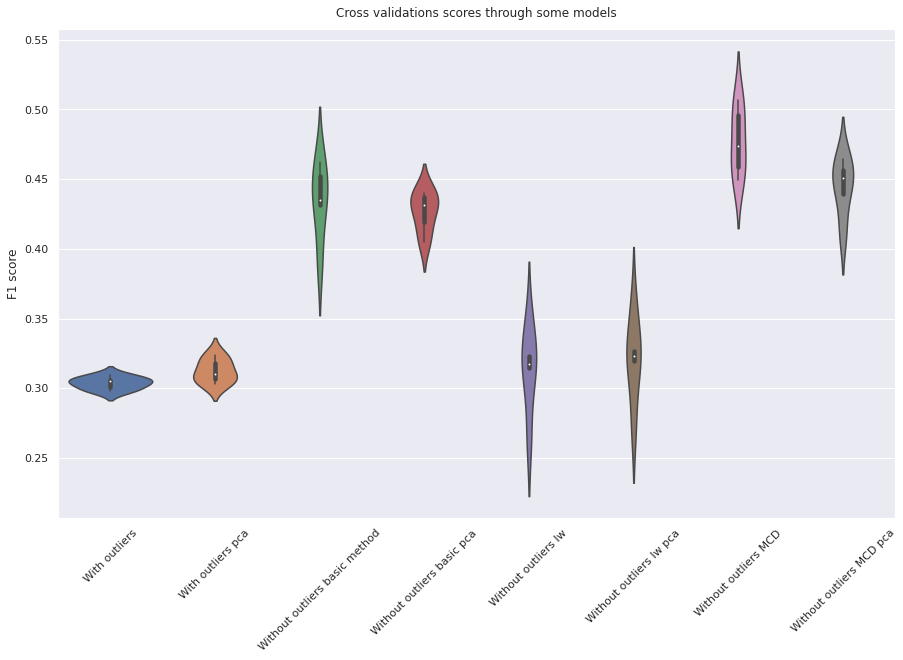

In [ ]:
plt.figure(figsize=((15, 9)))
scores_df = pd.DataFrame({"With outliers": scores_with_outliers, "With outliers pca": scores_with_outliers_pca, 
                          "Without outliers basic method": scores_basic, "Without outliers basic pca": scores_basic_pca,
                          "Without outliers lw": scores_lw, "Without outliers lw pca": scores_lw_pca,
                          "Without outliers MCD": scores_cmd, "Without outliers MCD pca": scores_cmd_pca})
g = sns.violinplot(data=scores_df, orient ='v')
g.set_title('Cross validations scores through some models', fontdict={'fontsize':12}, pad=12)
g.set_ylabel ("F1 score")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

### Conclusión modelos con distintos métodos de eliminación de outliers

* Se encontró que el método que mejor resultados entregó con la regresión logística fue la eliminación de outliers con el método del mínimo determinante de la matriz de covarianzas, hay una mejora sustancial, ya que con outliers se obtuvo un f1 score de 0.36 en promedio, mientras que sin outliers por método el mínimo determinante de la matriz de covarianzas mejoró a 0.47

* PCA parece mejorar o empeorar un poco los distintos métodos pero en definitiva la diferencia no es muy grande
* PCA no mejoró el desempeño del modelo con datos sin outliers por el método del mínimo determinante de la matriz de covarianzas, incluso empeora un poco el resultado

## Analisis Importancia de Variables en la explicacion del modelo

Ahora bien, despues de ahcer un analisis de correlaciones en la seccion pasada y luego de haber eliminado los outliers que hacen parte de en cada variable tanto univariante como multivariante. Vamor a realizar una analisis para evidenciar si de las variables que se habian resaltado en correlaciones, son las que mejor explican el modelo, o en su defecto, cuales debemos remover. Para esto analizaremos en una regresion logistica los datos mas importantes de las variables, entre esto el coeficiente de cada uno, el valor p y el Z-Score, esto lo podremos ver en mas detalle en la siguiente visualizacion.

In [ ]:
features = ['creditscore', 'gender', 'age', 'tenure', 'balance', 'numofproducts','hascrcard', 'isactivemember', 'estimatedsalary','geography_France', 'geography_Germany', 'geography_Spain']

lr = sm.Logit(y_without_outliers_cmd, sm.add_constant(X_without_outliers_cmd)).fit(disp=False)

print(lr.summary())

                           Logit Regression Results                           
Dep. Variable:                 exited   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8988
Method:                           MLE   Df Model:                           11
Date:                Mon, 07 Jun 2021   Pseudo R-squ.:                  0.3142
Time:                        17:41:12   Log-Likelihood:                -2668.9
converged:                       True   LL-Null:                       -3891.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.2077   3.27e+06  -6.76e-07      1.000    -6.4e+06     6.4e+06
creditscore          -0.0006      0.000     -1.506      0.132      -0.001       0.000
gender                0.

De esta tabla podemos resaltar varias cosas, primero el coeficiente de las variables. Este representa numericamente la representacion de la variable en la explicacion de la variable predecida. Por otro lado, tenemos el valor p y el Z-Score. Nos concentraremos en este ultimo.

In [ ]:
# calcula la deviance total de un modelo sobre un conjunto de datos
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


# calcula la deviance total de un modelo entrenado con un subconjunto de caracteristicas
def subset_deviance(model, selected_ids):
    #print(sorted(list(selected_ids)))
    X_selected = X_without_outliers_cmd.iloc[:, sorted(list(selected_ids))]
    model.fit(X_selected, y_without_outliers_cmd)
    return deviance(X_selected, y_without_outliers_cmd, model)


lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
# inicia seleccionando todas las caracteristicas
selected_ids = set(range(len(features)))
current_deviance = subset_deviance(lr, selected_ids)
while True:
    # cual es la deviance total si se remueve una caracteristica?
    deviances = [
        (subset_deviance(lr, selected_ids - set([idx])), idx)
        for idx in selected_ids]
    # encuentra una caracteristica para remover para minimizar el resultado de la deviance total
    min_deviance, feature_to_remove_idx = min(deviances)
    # la diferencia entre las deviances para los dos modelos siguen
    # distribucion chi-squared aproximada. Esto se como criterio de parada
    deviance_diff = min_deviance - current_deviance
    p_value = 1 - stats.chi2.cdf(deviance_diff, df=1)
    if p_value < 0.05:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_deviance = min_deviance
    print(f'REMOVE: {features[feature_to_remove_idx]}')

# nombre de las caracteristicas seleccionadas 
selected_ids = sorted(list(selected_ids))
features_selected = [features[i] for i in selected_ids]

REMOVE: hascrcard
REMOVE: gender
REMOVE: geography_Spain
REMOVE: geography_France
REMOVE: geography_Germany
REMOVE: isactivemember
REMOVE: tenure


En esta siguiente seccion, nos encargamos de revisar por cada variable el valor p. Si este es menor que el umbral de 0.05 sera considerado como una variable significativa para la explicacion del problema, de lo contrario sera removido, como se puede evidenciar en la salida del codigo anterior.

Basicamente en este caso lo que estamos haciendo es revisamos la desviacion de cada variable a estudiar, tenemos que la desviacion calculada tras hallar el valor p con la ayuda de la distribucion chi2 cumple nuestro humbra de ser menor a 0.05, consideramos esta variable como una significativa para el problema. Sin embargo, si supera el umbral, sera removida.

Es importante mencionar que la remocion de variables nos permiten complementar el analisis exploratiorio de correlaciones, mostrando que muchas de las variables a remover por medio de la desviacion de modelos (contando la regresion logistica), desde inicios del problema no tenian tanta importancia en la epxlicacion del fenomeno, con esto en mente removemos las variables y quedariamos con los siguientes.

In [ ]:
x_selected = X_without_outliers_cmd.iloc[:, selected_ids]
lr = sm.Logit(y_without_outliers_cmd, sm.add_constant(x_selected)).fit(disp=False)
print(lr.summary())

                           Logit Regression Results                           
Dep. Variable:                 exited   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8994
Method:                           MLE   Df Model:                            5
Date:                Mon, 07 Jun 2021   Pseudo R-squ.:                  0.2311
Time:                        17:41:20   Log-Likelihood:                -2992.5
converged:                       True   LL-Null:                       -3891.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.3105      0.316    -10.471      0.000      -3.930      -2.691
creditscore        -0.0007      0.000     -1.893      0.058      -0.001    2.37e-05
age                 0.1141      

De esta forma, estas seran las variables con las cuales explicaremos nuestro problema de la manera mas adecuada.

## Partición de datos en entrenamiento y de prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_without_outliers_cmd, 
                                                    y_without_outliers_cmd, 
                                                    train_size=0.8, 
                                                    random_state=random_state)
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(x_selected, y_without_outliers_cmd, train_size=0.8, random_state=random_state)

In [ ]:
def print_scores(model, X_test, y_test):
  y_predict = model.predict(X_test)
  print("ROC_AUC", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
  print(confusion_matrix(y_test, y_predict))
  print(classification_report(y_test, y_predict))

### Modelos antes de oversampling

In [ ]:
scaler = MinMaxScaler().fit(X_train)
scaler_filtered = MinMaxScaler().fit(X_train_filtered)

#### Logistic Regression

In [ ]:
# Modelo regresión logística en entrenamiento
print("All Variables ------------------------------------------------")
cross = cross_validate(LogisticRegression(), scaler.transform(X_train), y_train, scoring="f1", cv=cv, return_estimator=True)
model1 = cross["estimator"][0]
display_scores_cross_validation(cross["test_score"])
print("Filtered Variables ------------------------------------------------")
cross = cross_validate(LogisticRegression(), scaler_filtered.transform(X_train_filtered), y_train_filtered, scoring="f1", cv=cv, return_estimator=True)
model1 = cross["estimator"][0]
display_scores_cross_validation(cross["test_score"])

All Variables ------------------------------------------------
Scores: [0.44578313 0.48695652 0.50887574 0.46590909 0.43103448]
Mean: 0.46771179351638653
Standard deviation 0.027907601326545066
Filtered Variables ------------------------------------------------
Scores: [0.33557047 0.36190476 0.32996633 0.30819672 0.29315961]
Mean: 0.32575957842034925
Standard deviation 0.023628950825226622


In [ ]:
# Modelo regresión logística en entrenamiento PCA
print("All Variables ------------------------------------------------")
cross = cross_validate(pca_pipeline_logistic, X_train, y_train, scoring="f1", cv=cv, return_estimator=True)
model1 = cross["estimator"][0]
display_scores_cross_validation(cross["test_score"])

All Variables ------------------------------------------------
Scores: [0.45180723 0.47058824 0.46060606 0.39411765 0.43428571]
Mean: 0.44228097723207577
Standard deviation 0.026875600881664918


In [ ]:
# Modelo regresión logística en test
print("All Variables ------------------------------------------------")
model1 = LogisticRegression().fit(scaler.transform(X_train), y_train)
print_scores(model1, scaler.transform(X_test), y_test)
print("Filtered Variables ------------------------------------------------")
model1 = LogisticRegression().fit(scaler_filtered.transform(X_train_filtered), y_train_filtered)
print_scores(model1, scaler_filtered.transform(X_test_filtered), y_test_filtered)

All Variables ------------------------------------------------
ROC_AUC 0.8627369906278323
[[1467   51]
 [ 169  113]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1518
           1       0.69      0.40      0.51       282

    accuracy                           0.88      1800
   macro avg       0.79      0.68      0.72      1800
weighted avg       0.86      0.88      0.86      1800

Filtered Variables ------------------------------------------------
ROC_AUC 0.8221063549463179
[[1479   39]
 [ 203   79]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1518
           1       0.67      0.28      0.40       282

    accuracy                           0.87      1800
   macro avg       0.77      0.63      0.66      1800
weighted avg       0.85      0.87      0.84      1800



#### Random forest

In [ ]:
# Modelo random forest en entrenamiento
print("All Variables ------------------------------------------------")
cross = cross_validate(RandomForestClassifier(), scaler.transform(X_train), y_train, scoring="f1", cv=cv, return_estimator=True)
model1 = cross["estimator"][0]
display_scores_cross_validation(cross["test_score"])
print("Filtered Variables ------------------------------------------------")
cross = cross_validate(RandomForestClassifier(), scaler_filtered.transform(X_train_filtered), y_train_filtered, scoring="f1", cv=cv, return_estimator=True)
model1 = cross["estimator"][0]
display_scores_cross_validation(cross["test_score"])

All Variables ------------------------------------------------
Scores: [0.47129909 0.54143646 0.5648415  0.49577465 0.42690058]
Mean: 0.5000504577971421
Standard deviation 0.04920672289499109
Filtered Variables ------------------------------------------------
Scores: [0.4011976  0.41621622 0.4        0.37426901 0.33608815]
Mean: 0.38555419622491216
Standard deviation 0.028170203324558774


In [ ]:
# Modelo random forest en test
print("All Variables ------------------------------------------------")
scaler = MinMaxScaler().fit(X_train)
model2 = RandomForestClassifier().fit(scaler.transform(X_train), y_train)
print_scores(model2, scaler.transform(X_test), y_test)
print("Filtered Variables ------------------------------------------------")
scaler_filtered = MinMaxScaler().fit(X_train_filtered)
model2 = RandomForestClassifier().fit(scaler_filtered.transform(X_train_filtered), y_train_filtered)
print_scores(model2, scaler_filtered.transform(X_test_filtered), y_test_filtered)

All Variables ------------------------------------------------
ROC_AUC 0.8611204552462647
[[1472   46]
 [ 161  121]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1518
           1       0.72      0.43      0.54       282

    accuracy                           0.89      1800
   macro avg       0.81      0.70      0.74      1800
weighted avg       0.87      0.89      0.87      1800

Filtered Variables ------------------------------------------------
ROC_AUC 0.8012327250301348
[[1443   75]
 [ 195   87]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1518
           1       0.54      0.31      0.39       282

    accuracy                           0.85      1800
   macro avg       0.71      0.63      0.65      1800
weighted avg       0.83      0.85      0.83      1800



#### Conclusiones tras utilizar remocion de variables

A este punto tras revisar el comportamiento de los modelos al integrar menores variables, tuvimos una reduccion significativa para la comprension y prediccion del modelo. Esta tecnica a pesar de reducir la dimension de las variables a explicar, tuvo un impacto en la prediccion y catalogacion de los usuarios en un ambiente cercano a produccion (datos en test) por esta razon, a partir de este punto se utilizan las variables que nos produjeron un mejor valor en las metricas utilizadas.

#### K neighbors

In [ ]:
# Modelo knn en entrenamiento
cross = cross_validate(KNeighborsClassifier(), scaler.transform(X_train), y_train, scoring="f1", cv=cv, return_estimator=True)
model1 = cross["estimator"][0]
display_scores_cross_validation(cross["test_score"])

Scores: [0.42857143 0.43956044 0.45901639 0.45263158 0.40112994]
Mean: 0.4361819568049369
Standard deviation 0.020444947969818692


In [ ]:
scaler = MinMaxScaler().fit(X_train)
model3 = KNeighborsClassifier().fit(scaler.transform(X_train), y_train)
print_scores(model3, scaler.transform(X_test), y_test)

ROC_AUC 0.793684999859838
[[1443   75]
 [ 173  109]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1518
           1       0.59      0.39      0.47       282

    accuracy                           0.86      1800
   macro avg       0.74      0.67      0.69      1800
weighted avg       0.85      0.86      0.85      1800



## Oversampling random




In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=0)
x_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Frequency of unique values of the said array:
[[   0    1]
 [6081 6081]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


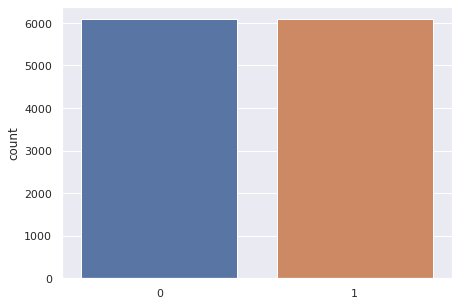

In [ ]:
unique_elements, counts_elements = np.unique(y_train_resampled, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
plt.figure(figsize=(7, 5))
sns.countplot(y_train_resampled)

# Modelos y evaluación


### Modelo regresión logística con oversampling random
Se puede observar que el modelo ha mejorado considerablemente ya que antes de oversampling se había obtenido 0.46 en el conjunto de entrenamiento, mientras que en entreamiento ahora se ha llegado a 0.77 si bien en el conjunto de prueba se llega a un 0.53, el modelo ha mejorado.

In [ ]:
# Modelo regresión logística en entrenamiento
scaler_resample = MinMaxScaler().fit(x_train_resampled)
cross = cross_validate(LogisticRegression(), scaler_resample.transform(x_train_resampled), y_train_resampled, scoring="f1", cv=cv, return_estimator=True)
scores_oversampling_lr = cross["test_score"]
model_oversampling_lr = cross["estimator"][0]
display_scores_cross_validation(scores_oversampling_lr)

Scores: [0.78495503 0.77782375 0.77763766 0.782955   0.78308208]
Mean: 0.7812907030021788
Standard deviation 0.00299234547004428


In [ ]:
# Modelo regresión logística en testing
print_scores(model_oversampling_lr, scaler_resample.transform(X_test), y_test)

ROC_AUC 0.8619404031059905
[[1170  348]
 [  55  227]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1518
           1       0.39      0.80      0.53       282

    accuracy                           0.78      1800
   macro avg       0.67      0.79      0.69      1800
weighted avg       0.87      0.78      0.80      1800



### Modelo random forest con oversampling random

*   List item
*   List item



Sin realizar oversampling el modelo había obtenido un f1-score de 0.52 prediciendo la clase 1, se observa que el modelo con oversampling ahora tiene un f1-score de 0.58, se redujo la precision, sin embargo aumentó el recall. 

In [ ]:
# Modelo random forest en entrenamiento
scaler_resample = MinMaxScaler().fit(x_train_resampled)
cross = cross_validate(RandomForestClassifier(), scaler_resample.transform(x_train_resampled), y_train_resampled, scoring="f1", cv=cv, return_estimator=True)
scores_oversampling_forest = cross["test_score"]
model_oversampling_forest = cross["estimator"][0]
display_scores_cross_validation(scores_oversampling_forest)

Scores: [0.96952686 0.95874263 0.96181966 0.96504034 0.96368829]
Mean: 0.9637635568933621
Standard deviation 0.0035732329859032835


In [ ]:
# Modelo random forest en test
X_test_scaled = scaler_resample.transform(X_test)
print_scores(model_oversampling_forest, X_test_scaled, y_test)

ROC_AUC 0.8585624982479747
[[1406  112]
 [ 120  162]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1518
           1       0.59      0.57      0.58       282

    accuracy                           0.87      1800
   macro avg       0.76      0.75      0.75      1800
weighted avg       0.87      0.87      0.87      1800



In [ ]:
# Importancia de cada feature
feature_importances = np.array(sorted(zip(model2.feature_importances_, X_train.columns), reverse=True))
feature_importances

array([['0.24829999885415335', 'gender'],
       ['0.24232450468571917', 'balance'],
       ['0.22318864892578066', 'creditscore'],
       ['0.20473343670390037', 'age'],
       ['0.0814534108304463', 'tenure']], dtype='<U32')

### Modelo de KNN con oversampling random

Sin realizar oversampling el modelo había obtenido un f1-score de 0.42 prediciendo la clase 1 en el conjunto de entrenamiento, se observa que el modelo con oversampling ahora tiene un f1-score de 0.85 en el conjunto de entrenamiento. Sin embargo en el conjunto de prueba el modelo pasó de 0.49 a 0.45, es decir que el modelo se ha sobreajustado a los datos pero no generaliza mejor


In [ ]:
# Modelo knn en entrenamiento
scaler_resample = MinMaxScaler().fit(x_train_resampled)
pd.DataFrame(x_train_resampled)
cross = cross_validate(KNeighborsClassifier(), scaler_resample.transform(x_train_resampled), y_train_resampled, scoring="f1", cv=cv, return_estimator=True)
scores_oversampling_knn = cross["test_score"]
model_oversampling_knn = cross["estimator"][0]
display_scores_cross_validation(scores_oversampling_knn)

Scores: [0.86631815 0.86334706 0.8712266  0.86642599 0.86482393]
Mean: 0.8664283454689512
Standard deviation 0.0026496721537756416


In [ ]:
# Modelo  knn en test
X_test_scaled = scaler_resample.transform(X_test)
print_scores(model_oversampling_knn, X_test_scaled, y_test)

ROC_AUC 0.7819989908334034
[[1122  396]
 [  73  209]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1518
           1       0.35      0.74      0.47       282

    accuracy                           0.74      1800
   macro avg       0.64      0.74      0.65      1800
weighted avg       0.85      0.74      0.77      1800



## Ensamble de modelos

En sí mismo RandomForest es un ensamble de árboles de decisión, sin embargo, es posible crear un clasificador usando los modelos usados hasta ahora. Para cada ejemplo se obtiene la probabilidad de que la clase sea 1 en cada modelo, luego se hace sobre todos y con eso se realiza la predicción final. Sin embargo, este modelo no mejora más de lo que funciona por sí solo RandomForest 


In [ ]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('logistic_regression', LogisticRegression()), 
                                          ('random_forest', RandomForestClassifier()), ('knn', KNeighborsClassifier())], voting='soft')
scaler_resample = MinMaxScaler().fit(x_train_resampled)
cross = cross_validate(voting_clf, scaler_resample.transform(x_train_resampled), y_train_resampled, scoring='f1', cv=cv, return_estimator=True)
scores_oversampling_voting = cross["test_score"]
model_oversampling_voting = cross["estimator"][0]
display_scores_cross_validation(scores_oversampling_voting)

Scores: [0.92337312 0.92154612 0.92241379 0.9237037  0.92205249]
Mean: 0.9226178444974072
Standard deviation 0.000807391383262546


In [ ]:
# Modelo voting en test
X_test_scaled = scaler_resample.transform(X_test)
print_scores(model_oversampling_voting, X_test_scaled, y_test)

ROC_AUC 0.8567941206701614
[[1262  256]
 [  75  207]]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1518
           1       0.45      0.73      0.56       282

    accuracy                           0.82      1800
   macro avg       0.70      0.78      0.72      1800
weighted avg       0.87      0.82      0.83      1800



## Búsqueda de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {"n_estimators": [25, 50, 100], 'max_features':[4,8,10]},
                { "bootstrap": [False],  "n_estimators":  [50, 100], 'max_features':[8,10]}
              ]
              
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=cv)
grid_search.fit(scaler_resample.transform(x_train_resampled), y_train_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=90, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_scor

In [ ]:
model_oversampling_grid = grid_search.best_estimator_

In [ ]:
# En train
from sklearn.model_selection import cross_validate
scores = cross_validate(model_oversampling_grid, scaler_resample.transform(x_train_resampled), 
                        y_train_resampled, cv=5, scoring="roc_auc", return_train_score=True)
scores_oversampling_grid = scores["test_score"]
display_scores_cross_validation(scores_oversampling_grid)

Scores: [0.99881037 1.         1.         1.         0.99876645]
Mean: 0.9995153634908964
Standard deviation 0.0005937185692283201


In [ ]:
# En test
X_test_scaled = scaler_resample.transform(X_test)
print_scores(model_oversampling_grid, X_test_scaled, y_test)

ROC_AUC 0.8309669311056915
[[1453   65]
 [ 164  118]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1518
           1       0.64      0.42      0.51       282

    accuracy                           0.87      1800
   macro avg       0.77      0.69      0.72      1800
weighted avg       0.86      0.87      0.86      1800



## Comparación de modelos

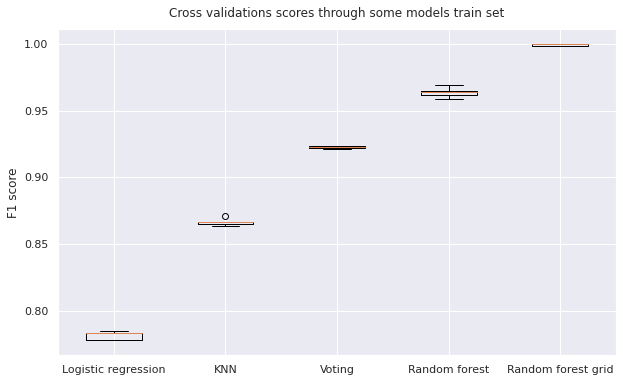

In [ ]:
# Comparison training set
scores_df = pd.DataFrame({"Logistic regression": scores_oversampling_lr, 
                          "KNN": scores_oversampling_knn, 
                          "Voting": scores_oversampling_voting,
                           "Random forest": scores_oversampling_forest,
                          "Random forest grid": scores_oversampling_grid
                          })
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.boxplot(scores_df.to_numpy())
ax.set_title('Cross validations scores through some models train set', fontdict={'fontsize':12}, pad=12)
ax.set_ylabel("F1 score")
ax.set_xticklabels(scores_df.columns)
plt.show()

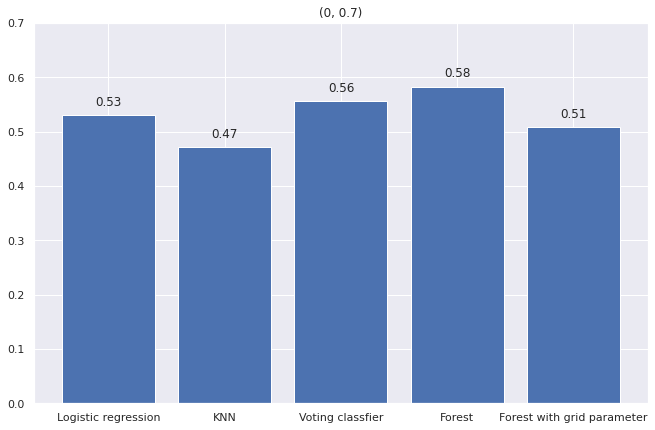

In [ ]:
f1_score_logistic = f1_score(y_test, model_oversampling_lr.predict(X_test_scaled))
f1_score_knn = f1_score(y_test, model_oversampling_knn.predict(X_test_scaled))
f1_score_voting = f1_score(y_test, model_oversampling_voting.predict(X_test_scaled))
f1_score_forest = f1_score(y_test, model_oversampling_forest.predict(X_test_scaled))
f1_score_grid = f1_score(y_test, model_oversampling_grid.predict(X_test_scaled))
columns = ["Logistic regression", "KNN", "Voting classfier", "Forest", "Forest with grid parameter"]

scores = pd.Series(data=[f1_score_logistic, f1_score_knn, f1_score_voting, f1_score_forest, f1_score_grid], index=columns)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))
ax.bar(x=columns, height=scores)

for x, y in zip(columns, scores):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
ax.set_ylim((0, 0.7))
ax.set_title((0, 0.7))
plt.show()    

# Conclusiones

1. El mejor clasificador fue Random Forest alcanzando un f1-score de 0.58

2. La búsqueda de hiperparámetros en el random forest logró que este se sobreajustara más al conjunto de entrenamiento y por eso no generaliza bien en el conjunto de prueba y no se desempeña también como el Random Forest sin ajuste de hiperparámetros

3. El voting classifier que fue un ensamble de modelos de knn, random forest y logistic regression, no supera al random forest por sí solo, presumiblemente los otros dos modelos le están sumando sus errores, afectando negativamente el puntaje del modelo.

4. El oversampling mejoró el f1 score de todos los modelos, especialmente el del Random Forest, ya que se pasó de un f1-score de 0.52 a 0.58

5. La regresión logística mejoró bastante con la eliminación de outliers a través del método del mínimo determinante de covarianzas, según estos resultados se puede concluir que este método era el más sensible a los outliers, por el contrario los otros métodos no se vieron muy afectados ni positiva ni negativamente.

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1518
           1       0.59      0.57      0.58       282

    accuracy                           0.87      1800
   macro avg       0.76      0.75      0.75      1800
weighted avg       0.87      0.87      0.87      1800



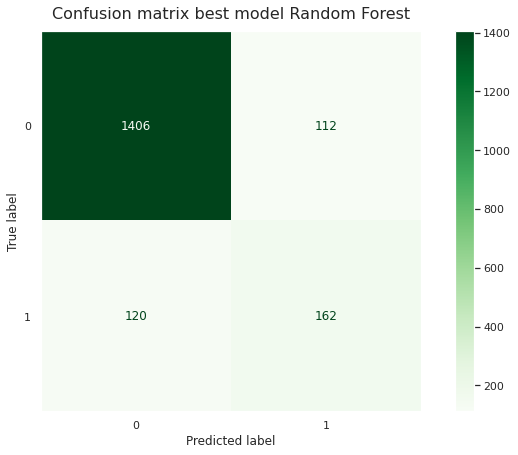

In [ ]:
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, model_oversampling_forest.predict(X_test_scaled), labels=model_oversampling_forest.classes_)
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.grid(False)
ax.set_title('Confusion matrix best model Random Forest',  fontdict={'fontsize':16}, pad=12)
plot_confusion_matrix(model_oversampling_forest, X_test_scaled, y_test, cmap="Greens", values_format='.0f', ax=ax)
print(classification_report(y_test, model_oversampling_forest.predict(X_test_scaled)))
plt.show()